In [1]:
# %load std_libraries.py
#to keep my scripts consistent, I am adding this to the top of all scripts with %load std_libraries.py
import sys
#Indicate operating environment and import core modules
location_input = input("what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = other")
location_dict = {'a': "C:\\Users\\BMH_work\\github\\expression_broad_data", 'b': "/home/heineike/github/expression_broad_data",
                 'c': "C:\\Users\\Ben\\Documents\\GitHub\\expression_broad_data", 'd':'you need to add your location to the location_dict'}
base_dir = location_dict[location_input]
print("base directory is " + base_dir)

if sys.path[-1] != base_dir:
    sys.path.append(base_dir)
    print("Added " + base_dir + " to path: " )
    print(sys.path)

import os

print("I am about to import a library")
from core import expression_plots 
from core import io_library 
%load_ext autoreload
%autoreload 2
# %matplotlib 
# plt.ioff()
#%matplotlib inline
%matplotlib notebook
data_processing_dir = base_dir + os.sep + os.path.normpath("expression_data") + os.sep

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import matplotlib.colormap as cm
from matplotlib_venn import venn2
from matplotlib_venn import venn3
#for my windows10 laptop I had to install this package using pip rather than anaconda.  
import seaborn as sns; sns.set(style="ticks", color_codes=True)
#from sklearn import linear_model
import pickle
#import subprocess
#import networkx as nx
import scipy.stats as stats
import scipy.spatial.distance as spd
import statsmodels.api as sm
#import statsmodels.graphics.gofplots as stats_graph
import scipy.cluster.hierarchy as sch

# from Bio import SeqIO
# from Bio import SeqFeature as sf
# from Bio.Alphabet import generic_dna
# from Bio.Seq import Seq

# import re

from collections import Counter
# import scipy.stats as stats
from itertools import chain
#from itertools import product
#this only works if you are online
online_input = input("are you online? Yes/No ")
if online_input == "Yes": 
    import plotly.plotly as py
    import plotly.graph_objs as pygo
    import plotly.tools as pytools
    py.sign_in('heineike02_student','9dMTMZgJMgUP0YX0P5mQ')
    #py.sign_in('heineike02', 'APPjKrtARaN2ZgUYIkqr')
    
# for phylogenetic trees: 
# from ete3 import Tree
#ete3 is not officially supported on windows, and so must be loaded via pip: 
# pip install -U https://github.com/etetoolkit/ete/archive/qt5.zip
# ref: https://groups.google.com/forum/#!topic/etetoolkit/6NblSBPij4o

#for scraping internet data (e.g. ncbi)
#import requests
#from lxml import etree    #parses xml output

spec_lookup = {'Klac' : 'Kluyveromyces lactis', 'Scer': 'Saccharomyces cerevisiae', 
 'Cgla' : 'Candida glabrata' , 'Ncas': 'Naumovozyma castellii', 
 'Sbay' : 'Saccharomyces bayanus', 'Smik': 'Saccharomyces mikatae',
 'Lwal' : 'Lachancea waltii', 'Spar' : 'Saccharomyces paradoxus', 
 'Lklu' : 'Lachancea kluyverii', 'Dhan': 'Debaryomyces hansenii', 
 'Calb' : 'Candida albicans', 'Ylip': 'Yarrowia lipolytica'}

what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = othera
base directory is C:\Users\BMH_work\github\expression_broad_data
Added C:\Users\BMH_work\github\expression_broad_data to path: 
['', 'C:\\Users\\BMH_work\\github\\expression_broad_data\\scripts', 'C:\\Users\\BMH_work\\Anaconda3\\python37.zip', 'C:\\Users\\BMH_work\\Anaconda3\\DLLs', 'C:\\Users\\BMH_work\\Anaconda3\\lib', 'C:\\Users\\BMH_work\\Anaconda3', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\win32', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\win32\\lib', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\Pythonwin', 'C:\\Users\\BMH_work\\Anaconda3\\lib\\site-packages\\IPython\\extensions', 'C:\\Users\\BMH_work\\.ipython', 'C:\\Users\\BMH_work\\github\\expression_broad_data']
I am about to import a library
I am importing io_library
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = other

In [2]:
#Load GOI ohnolog data

fname = data_processing_dir + os.sep + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_20181205.pkl')

with open(fname, 'rb') as file:
    [ohnologs_goi,ohnologs_expression_sorted,goi_criteria] = pickle.load(file)

#Load kl_sc_PKA data

fname_cross_spec_comparison = data_processing_dir + os.path.normpath("kl_sc_PKA_as_m24_r1g1_20181017/cross_species_compare_ASminus_ASplus_YPD_20181204.csv")
kl_sc_PKA_data = pd.read_csv(fname_cross_spec_comparison, index_col=0)

#Merge LFC data from KL with rest of ohnolog data
ohnologs_goi_kl_data = ohnologs_goi.merge(kl_sc_PKA_data.loc[:,
                    ['N SCer Orthologs', 'kl_genename', 'sc_genename', 'baseMean_KL',
                    'log2FoldChange_KL', 'lfcSE_KL', 'stat_KL', 'pvalue_KL', 'padj_KL']],
                    how='left', left_on = 'sc_genename_high', right_on = 'sc_genename')


#Load KL ortholog data
kl_orthologs = pd.read_pickle(data_processing_dir + "ortholog_files_YGOB/kl_orthologs.pkl")

#load average rlog data
rlog_data_mean_var = {}
for spec in ['SC', 'KL']:
    rlog_data_mean_var[spec] = pd.read_csv(os.path.normpath(data_processing_dir + '\\kl_sc_PKA_as_m24_r1g1_20181017\\20181017_rlog_mean_' + spec + '.csv' ),index_col=0)

#Rename KL rlog data columns: 
new_kl_columns = [column + '_kl' for column in rlog_data_mean_var['KL'].columns]
rlog_data_mean_var['KL'].columns = new_kl_columns

#Merge k.lac rlog data with ohnolog_gois
ohnologs_goi_klorth = ohnologs_goi.merge(kl_orthologs, how='left', left_on='sc_genename_low',right_on='sc_genename')
ohnologs_goi_rlog = ohnologs_goi_klorth.merge(rlog_data_mean_var['KL'], how = 'left', left_on='kl_genename', right_index = True)
    

In [64]:
# #Build platform dicts, raw exp data sets and expression datasets

# id_source_data_inds = {'Klac': 'GSE22198', 'Scer': 'GSE22204', 
#                         'Cgla':'GSE22194', 'Ncas' : 'GSE22200', 
#                         'Sbay' : 'GSE22205', 'Smik': 'GSE22201', 
#                         'Lwal': 'GSE22199', 'Spar': 'GSE22193', 
#                         'Lklu': 'GSE22202', 'Dhan': 'GSE22191', 
#                         'Calb': 'GSE22197', 'Ylip': 'GSE22192'}

# spec_list =   list(id_source_data_inds.keys()) + ['Vpol','Sjap','Spom', 'Suva'] 
# io_library.make_data_tables(spec_list)

In [39]:
#S.Cer

spec = 'Scer'

#Load expression data
fname = data_processing_dir + os.sep + os.path.normpath('regev_data/raw_exp/' + spec + '_raw_exp.csv')
raw_exp_tsankov = pd.read_csv(fname, index_col='orf_name')

# #Take mean of all data that has more than one spot per orf
# #Also only select out column of mean expression across replicates
# grouped = raw_exp_tsankov.groupby('orf_name')
# raw_exp_tsankov_mean = grouped.mean().loc[:,'Mean']

for level in ['low','high']: 
    raw_exp_tsankov_mean_level = raw_exp_tsankov['med_qnorm'].reindex(list(ohnologs_goi_rlog['sc_genename_' + level]))
    ohnologs_goi_rlog[spec + '_raw_exp_tsankov_' + level] = list(raw_exp_tsankov_mean_level)

    
#K.Lac
spec = 'Klac'

fname = data_processing_dir + os.sep + os.path.normpath('regev_data/raw_exp/' + spec + '_raw_exp.csv')
raw_exp_tsankov = pd.read_csv(fname, index_col = 'orf_name')

#Take mean of all data that has more than one spot per orf
#Also only select out column of mean expression across replicates

#add data to dataframe
raw_exp_tsankov_mean_goi = raw_exp_tsankov['med_qnorm'].reindex(list(ohnologs_goi_rlog['kl_genename']))
ohnologs_goi_rlog[spec + '_raw_exp_tsankov_YGOB'] = list(raw_exp_tsankov_mean_goi)


In [132]:
colors = {'low': 'blue', 'high': 'red'}

hover_text = []
#might be nice to add kl LFC to this
for ind, row in ohnologs_goi_rlog.iterrows():
    hover_text.append(('Low Paralog: {SC_common_name_low}<br>  LFC: {LFC_low:.2f}<br>  -log10(pval): {pval_low:.2f}<br>' +
                       'High Paralog: {SC_common_name_high}<br>  LFC: {LFC_high:.2f}<br>  -log10(pval): {pval_high:.2f}<br>' +
                       'KL genename: {kl_genename}').format(
                        SC_common_name_low = row['SC_common_name_low'],
                        LFC_low = row['log2FoldChange_low'],
                        pval_low = -np.log10(row['pvalue_low']),
                        SC_common_name_high = row['SC_common_name_high'],
                        LFC_high = row['log2FoldChange_high'],
                        pval_high = -np.log10(row['pvalue_high']),
                        kl_genename = row['kl_genename'])
                      )
data = []
corr_coef = {}
for level in ['low','high']:
    xdata = ohnologs_goi_rlog['AS_WT_cont_mean_' + level]
    ydata = ohnologs_goi_rlog['Scer_raw_exp_tsankov_' + level]
    
    trace = pygo.Scatter(
                x = xdata, 
                y = ydata,
                text = hover_text,
                mode = 'markers',
                marker = {'opacity': 0.9,  
                          'color': colors[level],
                          'size': 10}, 
                name = 'SCer ' + level + ' induction paralogs'
            )

    data.append(trace)
    
    #Remove NA and get correlation coefficient
    xy_data = pd.DataFrame()
    xy_data['xdata']=xdata
    xy_data['ydata']=ydata
    xy_data_nanrm = xy_data[((~xy_data['xdata'].isna()) & (~xy_data['ydata'].isna()) )]
    corr_coef['Scer_'+level] = np.corrcoef(xy_data_nanrm.T)[0][1]
    
    
    
xdata = ohnologs_goi_rlog['AS_WT_cont_mean_kl']
ydata = ohnologs_goi_rlog['Klac_raw_exp_tsankov_YGOB']
trace = pygo.Scatter(
                x = xdata , 
                y = ydata ,
                text = hover_text,
                mode = 'markers',
                marker = {'opacity': 0.9,  
                          'color': 'green',
                          'size': 10}, 
                name = 'KLac orthologs'
            )

data.append(trace)

#Remove NA and get correlation coefficient
xy_data = pd.DataFrame()
xy_data['xdata']=xdata
xy_data['ydata']=ydata
xy_data_nanrm = xy_data[((~xy_data['xdata'].isna()) & (~xy_data['ydata'].isna()) )]
corr_coef['Klac'] = np.corrcoef(xy_data_nanrm.T)[0][1]

annotation_text = 'Correlation Coeff <br>'
for gene_set, corr in corr_coef.items():
    annotation_text = annotation_text + '{} : {:.2f} <br>'.format(gene_set,corr)

layout = pygo.Layout(
    xaxis= {
        #"range":[-20, 20],
        "title": 'rlog'
    },
    yaxis= {
        #"range":[-10, 10],
        "title": 'LFC mRNA / gDNA'
    },
    annotations=[
        dict(
            x=13,
            y=-5,
            xref='x',
            yref='y',
            text=annotation_text,
            showarrow=False
        )
    ]
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename= 'rlog_vs_tsankov')

Supp Figure [rlog vs tsankov] The raw expression data from Tsankov et al [ref ??] is correlated with our rlog data.  rlog data for our differentially expressed paralogs in PKA(AS) cells grown for 45 min with DMSO are shown on the x axis.  Data from microarrays in which mRNA in cells in exponential growth phase in ??? media were competitively hybridized against genomic DNA.  NA values are removed.  

{'whiskers': [<matplotlib.lines.Line2D at 0x29e832810b8>,
 'caps': [<matplotlib.lines.Line2D at 0x29e835f3128>,
 'boxes': [<matplotlib.lines.Line2D at 0x29e83276278>,
 'medians': [<matplotlib.lines.Line2D at 0x29e82f8a438>,
 'fliers': [<matplotlib.lines.Line2D at 0x29e82f8ab70>,
 'means': []}

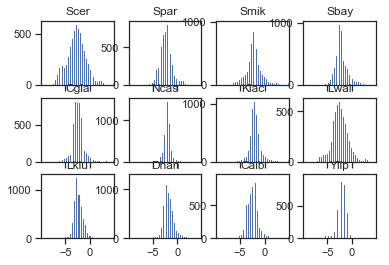

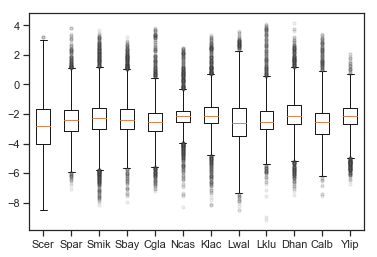

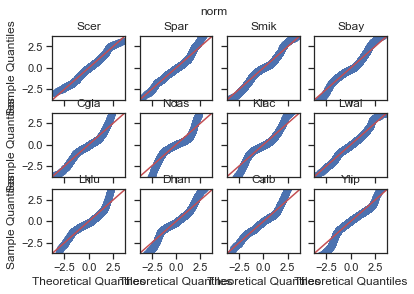

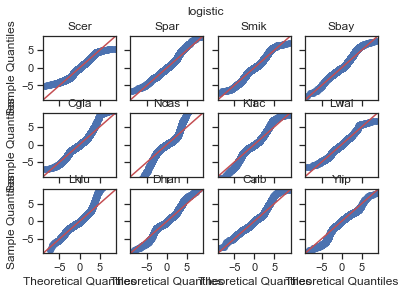

In [40]:
#Load all the data and check the distribution

fig_hist, axarr_hist = plt.subplots(3,4, sharex = True)

fig_boxplot, ax_boxplot = plt.subplots()

figs_qq = {}
axarr_qq = {}
dist_dict = dist_dict = {'norm': stats.norm , 'logistic': stats.logistic}

for dist_name in dist_dict.keys():
    figs_qq[dist_name], axarr_qq[dist_name] = plt.subplots(3,4, sharex = True, sharey = True)
    figs_qq[dist_name].suptitle(dist_name)
                                                           
spec_order_post_WGH = ['Scer','Spar','Smik','Sbay', 'Cgla', 'Ncas']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']

raw_exp_tsankov_all = {}

boxplot_data = []

for jj, spec in enumerate(spec_order_post_WGH+spec_order_pre_WGH) : 
    #Load expression data
    fname = data_processing_dir + os.sep + os.path.normpath('regev_data/raw_exp/' + spec + '_raw_exp.csv')
    raw_exp_tsankov = pd.read_csv(fname, index_col = 'orf_name')
    raw_exp_tsankov_all[spec] = raw_exp_tsankov['med_qnorm']
    boxplot_data.append(raw_exp_tsankov_all[spec])
    ax_hist = axarr_hist.flatten()[jj]
    ax_hist.hist(raw_exp_tsankov_all[spec], bins=30)
    ax_hist.set_title(spec)
    
    
    for dist_name, dist in dist_dict.items(): 
        ax_qq = axarr_qq[dist_name].flatten()[jj]
        sm.qqplot(raw_exp_tsankov_all[spec], dist = dist, fit = True, line = '45', ax = ax_qq )
        ax_qq.set_title(spec)
    
        ax_qq.set_ylabel('')
        ax_qq.set_xlabel('')
        if jj in [0,4,8]:
            ax_qq.set_ylabel('Sample Quantiles')
        if jj in [8,9,10,11]: 
            ax_qq.set_xlabel('Theoretical Quantiles')

flierprops = dict(marker='o', markerfacecolor='grey', markersize=3,
                  linestyle='none', alpha = 0.1)
ax_boxplot.boxplot(boxplot_data, whis=2.0, labels = spec_order_post_WGH+spec_order_pre_WGH, flierprops=flierprops)    



The distributions of expression between the different species seems different.  Some are more normal than others (SCer, LWal)  and some look more logistic than others  (SPar, SBay, Dhan, YLip).  As a rough comparison, I will just assume a standard normal distribution and scale by mean and variance.  In particular S.Cer seems to have a much wider variance - I am imagining that the microarray for S.Cer had a lot more probes for lower expressing genes - and maybe the probes for the other species were constrained to those that were highest expressing?   

{'whiskers': [<matplotlib.lines.Line2D at 0x29e8303bf28>,
 'caps': [<matplotlib.lines.Line2D at 0x29efc8e4748>,
 'boxes': [<matplotlib.lines.Line2D at 0x29e8303b780>,
 'medians': [<matplotlib.lines.Line2D at 0x29efd388da0>,
 'fliers': [<matplotlib.lines.Line2D at 0x29efd388860>,
 'means': []}

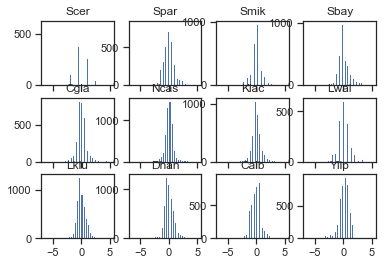

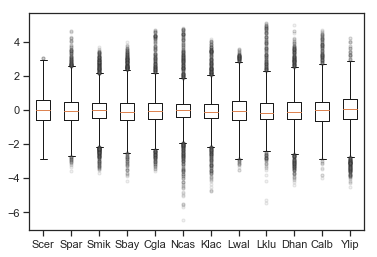

In [41]:
#Normalize all the raw expression data by mean and std (although we know they are not all normal)

fig_hist, axarr_hist = plt.subplots(3,4, sharex = True)

fig_boxplot, ax_boxplot = plt.subplots()


raw_exp_tsankov_all_norm = {}

boxplot_data = []
for jj, spec in enumerate(spec_order_post_WGH+spec_order_pre_WGH) : 
    std = raw_exp_tsankov_all[spec].std()
    mu = raw_exp_tsankov_all[spec].mean()
    raw_exp_tsankov_all_norm[spec] = (raw_exp_tsankov_all[spec]-mu)/std

    boxplot_data.append(raw_exp_tsankov_all_norm[spec])
    ax_hist = axarr_hist.flatten()[jj]
    ax_hist.hist(raw_exp_tsankov_all_norm[spec], bins=30)
    ax_hist.set_title(spec)

flierprops = dict(marker='o', markerfacecolor='grey', markersize=3,
                  linestyle='none', alpha = 0.1)
ax_boxplot.boxplot(boxplot_data, whis=2.0, labels = spec_order_post_WGH+spec_order_pre_WGH, flierprops=flierprops)    


In [42]:
#Post WGH data
spec_order_post_WGH = ['Spar','Smik','Sbay', 'Cgla', 'Ncas']
#Smik missing mapping from ygob names to Regev lab orthogroups.  C.Gla mapping for Sec14 seems better with orthogroups than YGOB
#Going to start with orthogroup mapping from Regev lab for all of them. 
#K.Lac had a major discrepancy with annotation in regev lab data.   

#Species that have a column on the pillars file: 'Klac, Lwal, Lklu, Scer, Smik, Cgla, Ncas'
#Should also do one with Pillars orthologs

orth_dir = data_processing_dir + 'ortholog_files' + os.sep 

for spec in spec_order_post_WGH: 
    #load ortholog mapping

    sc_spec_orth_lookup = io_library.read_orth_lookup_table('Scer', spec, orth_dir)

    #Load expression data
    raw_exp_tsankov_norm = raw_exp_tsankov_all_norm[spec]

    for level in ['low','high']: 
        raw_exp_tsankov_norm_level = []
        for gene in ohnologs_goi_rlog['sc_genename_' + level ]: 
            try: 
                if sc_spec_orth_lookup[gene][0]=='NONE':
                    raw_exp_tsankov_norm_level.append('NONE_in_orthogroups')
                else: 
                    raw_exp_list = [raw_exp_tsankov_norm[spec_gene] for spec_gene in sc_spec_orth_lookup[gene]]
                    raw_exp_tsankov_norm_level.append(raw_exp_list) 
            except KeyError:
                print(gene + ' has no ortholog in ' + spec)
                raw_exp_tsankov_norm_level.append('NONE_not_in_orthogroups')
        ohnologs_goi_rlog[spec + '_raw_exp_tsankov_' + level] = list(raw_exp_tsankov_norm_level)



spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']

for spec in spec_order_pre_WGH: 

    #load ortholog mapping

    orth_dir = data_processing_dir + 'ortholog_files' + os.sep 
    sc_spec_orth_lookup = io_library.read_orth_lookup_table('Scer', spec, orth_dir)

    raw_exp_tsankov_norm = raw_exp_tsankov_all_norm[spec]

    raw_exp_tsankov_norm_spec = []
    for row in ohnologs_goi_rlog.loc[:,['sc_genename_low','sc_genename_high']].iterrows():
        gene_low = row[1]['sc_genename_low']
        gene_high = row[1]['sc_genename_high']

        try:         
            if sc_spec_orth_lookup[gene_low] == sc_spec_orth_lookup[gene_high]: 
                gene_to_test = gene_low
                if sc_spec_orth_lookup[gene_to_test][0]=='NONE':
                    raw_exp_tsankov_norm_spec.append('NONE_in_orthogroups')
                else: 
                    raw_exp_list = []
                    for spec_gene in sc_spec_orth_lookup[gene_to_test]: 
                        try: 
                            raw_exp_list.append(raw_exp_tsankov_norm[spec_gene])
                        except KeyError: 
                            print(spec_gene + ' not in tsankov raw_exp dataset for ' + spec)
                            raw_exp_list.append('NONE_not_in_tsankov_microarray')
                    raw_exp_tsankov_norm_spec.append(raw_exp_list) 
            else: 
                print('high and low paralogs do not match ' + gene_low + ' and ' + gene_high )
        except KeyError: 
            print('either ' + gene_low + ' or ' + gene_high + ' has no ortholog in ' + spec)     
            gene_to_test = 'NONE'
            if gene_low in sc_spec_orth_lookup.keys():
                gene_to_test = gene_low
            elif gene_high in sc_spec_orth_lookup.keys():
                gene_to_test = gene_high

            if gene_to_test != 'NONE':
                print(gene_to_test + ' did have an ortholog in ' + spec)
                if sc_spec_orth_lookup[gene_to_test][0]=='NONE':
                    raw_exp_tsankov_norm_spec.append('NONE_in_orthogroups')
                else: 
                    raw_exp_list = []
                    for spec_gene in sc_spec_orth_lookup[gene_to_test]: 
                        try: 
                            raw_exp_list.append(raw_exp_tsankov_norm[spec_gene])
                        except KeyError: 
                            print(spec_gene + ' not in tsankov raw_exp dataset for ' + spec)
                            raw_exp_list.append('NONE_not_in_tsankov_microarray')
                    raw_exp_tsankov_norm_spec.append(raw_exp_list) 
            else:
                print('neither ' + gene_low + ' nor ' + gene_high + ' has an ortholog in ' + spec)
                raw_exp_tsankov_norm_spec.append('NONE_not_in_orthogroups')
    
    ohnologs_goi_rlog[spec + '_raw_exp_tsankov'] = list(raw_exp_tsankov_norm_spec)
    



YBR056W-A has no ortholog in Spar
YBR056W-A has no ortholog in Smik
YBR056W-A has no ortholog in Sbay
YNL052W has no ortholog in Cgla
YBR056W-A has no ortholog in Cgla
YHR092C has no ortholog in Cgla
YIL111W has no ortholog in Cgla
YDR342C has no ortholog in Cgla
YHR096C has no ortholog in Cgla
YDR524C-B has no ortholog in Ncas
YNL052W has no ortholog in Ncas
YBR056W-A has no ortholog in Ncas
YGR131W has no ortholog in Ncas
YLR043C has no ortholog in Ncas
YHR108W has no ortholog in Ncas
YLR293C has no ortholog in Ncas
YLR297W has no ortholog in Ncas
YOR375C has no ortholog in Ncas
YFL048C has no ortholog in Ncas
YCL048W-A has no ortholog in Ncas
YNR001C has no ortholog in Ncas
YNL093W has no ortholog in Ncas
YNL055C has no ortholog in Ncas
YIL113W has no ortholog in Ncas
YLR031W has no ortholog in Ncas
YKL091C has no ortholog in Ncas
YDL021W has no ortholog in Ncas
YDR034W-B has no ortholog in Ncas
YLR346C has no ortholog in Ncas
YGR256W has no ortholog in Ncas
YJL045W has no ortholog 

In [43]:
columns_to_view = ['SC_common_name_high', 'SC_common_name_low','Scer_raw_exp_tsankov_low',
       'Scer_raw_exp_tsankov_high', 'Klac_raw_exp_tsankov',
       'Spar_raw_exp_tsankov_low', 'Spar_raw_exp_tsankov_high',
       'Smik_raw_exp_tsankov_low', 'Smik_raw_exp_tsankov_high',
       'Sbay_raw_exp_tsankov_low', 'Sbay_raw_exp_tsankov_high',
       'Cgla_raw_exp_tsankov_low', 'Cgla_raw_exp_tsankov_high',
       'Ncas_raw_exp_tsankov_low', 'Ncas_raw_exp_tsankov_high',
       'Klac_raw_exp_tsankov_YGOB', 'Lwal_raw_exp_tsankov',
       'Lklu_raw_exp_tsankov', 'Dhan_raw_exp_tsankov', 'Calb_raw_exp_tsankov',
       'Ylip_raw_exp_tsankov','AS_WT_cont_mean_high','AS_WT_cont_mean_low','AS_WT_cont_mean_kl']

In [44]:
ohnologs_goi_rlog.loc[ohnologs_goi_rlog['SC_common_name_high']=='PYK2',columns_to_view].T

,66
SC_common_name_high,PYK2
SC_common_name_low,CDC19
Scer_raw_exp_tsankov_low,2.57011
Scer_raw_exp_tsankov_high,-4.62704
Klac_raw_exp_tsankov,[2.6312935012349428]
Spar_raw_exp_tsankov_low,[4.328497370870005]
Spar_raw_exp_tsankov_high,[-0.47449058751842393]
Smik_raw_exp_tsankov_low,[3.3451069809009706]
Smik_raw_exp_tsankov_high,[0.5004437484679656]
Sbay_raw_exp_tsankov_low,[3.3279583568097957]


In [292]:
ohnologs_goi_rlog['SC_common_name_high']

0     YCL048W-A
1          ALP1
2          TPK1
3          PIR3
4         DAL80
5          PRY1
6         YSC84
7          CMK1
8          HEF3
9          CIT1
10         CYC7
11         PRM6
12         ADY3
13        YPT53
14         POR1
15         SDP1
16        COX5B
17         NDE2
18      YLR031W
19        ADE16
20         PGM2
21      YKL091C
22         STB2
23         RTC2
24         GPD1
25         GPM2
26      YDR018C
27    YDR034W-B
28         PST1
29         UBC5
        ...    
61         TOS8
62         USV1
63        HSP82
64    YNR034W-A
65         GDH3
66         PYK2
67        FUN19
68         FRT2
69         PSK1
70      YIR016W
71         RNR3
72         SNF3
73         SHC1
74         UBP9
75         AVT6
76        SCS22
77      YPR172W
78        EMP46
79      YFL042C
80         AFR1
81         CRF1
82         RTN2
83         VHS1
84         SSE2
85      YOR214C
86         ODC1
87         HER1
88         HES1
89        URA10
90         NGL3
Name: SC_common_name_hig

<IPython.core.display.Javascript object>


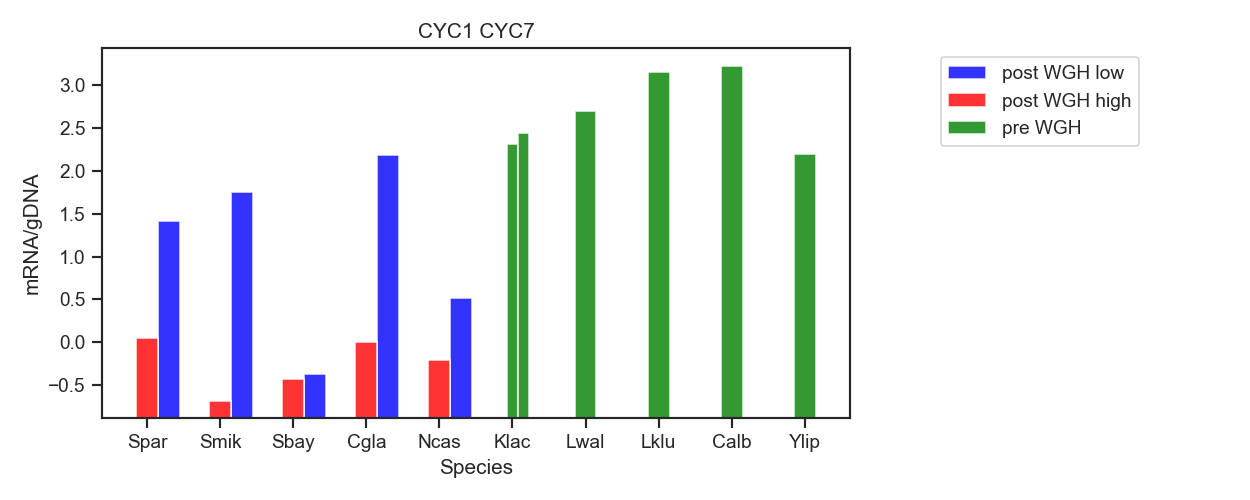

In [189]:
high_gene = 'CYC7'
row = ohnologs_goi_rlog[ohnologs_goi_rlog['SC_common_name_high']==high_gene]

fig, ax = plt.subplots(figsize = (10,4))
bar_width = 0.30
opacity = 0.8

spec_order_post_WGH = ['Spar','Smik','Sbay', 'Cgla', 'Ncas'] #['Scer','Spar','Smik','Sbay', 'Cgla', 'Ncas']
spec_order_pre_WGH = ['Klac','Lwal','Lklu', 'Calb', 'Ylip'] #['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']


# data to plot

data = {}
index_post_WGH = {}
index_shift = {'high': 0.0, 'low': bar_width}
bar_width_post_WGH = {}
for level in ['high','low']: 
    index_post_WGH_level = []
    data_level = []
    bar_width_post_WGH_level = []
    for jj, spec in enumerate(spec_order_post_WGH): 
        raw_exp_values = row[spec + '_raw_exp_tsankov_' + level].values[0]
        
        if isinstance(raw_exp_values,str): #The value will be a string if there was no expression value
            index_post_WGH_level.append(jj)
            data_level.append(0)
            bar_width_post_WGH_level.append(bar_width)
        elif spec == 'Scer':  #Scer values are floats, not lists
            index_post_WGH_level.append(jj)
            data_level.append(raw_exp_values)
            bar_width_post_WGH_level.append(bar_width)
        else: 
            for kk, raw_exp_value in enumerate(raw_exp_values):
                index_post_WGH_level.append(jj + bar_width*kk/len(raw_exp_values))
                if isinstance(raw_exp_value,str):
                    raw_exp_value=0.0
                data_level.append(raw_exp_value)
                bar_width_post_WGH_level.append(bar_width/len(raw_exp_values))

    data[level] = data_level
    index_post_WGH[level] = np.array(index_post_WGH_level) + index_shift[level]
    bar_width_post_WGH[level] = bar_width_post_WGH_level


index_shift = len(spec_order_post_WGH)
index_pre_WGH = []
data_pre_WGH = []
bar_width_pre_WGH = []
for jj, spec in enumerate(spec_order_pre_WGH): 
    raw_exp_values = row[spec + '_raw_exp_tsankov'].values[0]
    if isinstance(raw_exp_values,str): #The value will be a string if there was no expression value
        index_pre_WGH.append(jj)
        data_pre_WGH.append(0)
        bar_width_pre_WGH.append(bar_width)
    else: 
        for kk, raw_exp_value in enumerate(raw_exp_values):
            index_pre_WGH.append(jj + bar_width*kk/len(raw_exp_values))
            if isinstance(raw_exp_value,str):
                raw_exp_value= np.nan  #0.0
            data_pre_WGH.append(raw_exp_value)
            bar_width_pre_WGH.append(bar_width/len(raw_exp_values))

index_pre_WGH = np.array(index_pre_WGH) + index_shift

#Set bottom of bar to be the lowest number in all the data

bottom = min(data['low']+data['high']+data_pre_WGH)-0.2

rects_low = plt.bar(index_post_WGH['low'], np.array(data['low'])-bottom, bar_width_post_WGH['low'],
                 alpha=opacity,
                 color='blue',
                 label='post WGH low', 
                 bottom = bottom)
 
rects_high = plt.bar(index_post_WGH['high'], np.array(data['high'])-bottom, bar_width_post_WGH['high'],
                 alpha=opacity,
                 color='red',
                 label='post WGH high', 
                 bottom = bottom)

rects_pre_WGH = plt.bar(index_pre_WGH, np.array(data_pre_WGH)-bottom, bar_width_pre_WGH,
                 alpha=opacity,
                 color='green',
                 label='pre WGH', 
                 bottom = bottom)
 
plt.xlabel('Species')
plt.ylabel('mRNA/gDNA')
plt.title(row['SC_common_name_low'].values[0] + ' ' + row['SC_common_name_high'].values[0])
plt.xticks(np.arange(len(spec_order_post_WGH)+len(spec_order_pre_WGH)), spec_order_post_WGH + spec_order_pre_WGH)
plt.legend(bbox_to_anchor=(1.4,1.0))
 
plt.tight_layout()
plt.show()

In [47]:
#Go through each of my GOIs and make a vector.
#If there are no orthologs, set the value to np.Nan
#If there is an unexpected duplicate gene set the value to the mean expression between the two

spec_order_post_WGH = ['Scer','Spar','Smik','Sbay', 'Cgla', 'Ncas']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip']

raw_expression_data = {}

for row in ohnologs_goi_rlog.itertuples(): 
    high_gene_common_name = getattr(row, 'SC_common_name_high') 
    low_gene_common_name = getattr(row, 'SC_common_name_low')
    
    raw_expression_data_row = []
    
    for level in ['low', 'high']: 
        for spec in spec_order_post_WGH:
            raw_exp_values = getattr(row, spec + '_raw_exp_tsankov_' + level)
            raw_expression_data_row.append(raw_exp_values)
    
    for spec in spec_order_pre_WGH:
        raw_exp_values = getattr(row, spec + '_raw_exp_tsankov')
        raw_expression_data_row.append(raw_exp_values)
        
    
    raw_expression_data_row_clean = []
    for point in raw_expression_data_row: 
        if isinstance(point, str): 
            raw_expression_data_row_clean.append(np.nan)
        elif isinstance(point,list):   #data from most species is a list - in case there is more than one ortholog
            Nstr = sum([isinstance(item, str) for item in point])
            if Nstr > 0:  #if at least one item is a string
                if Nstr == len(point):   #none of the orthologs have data
                    raw_expression_data_row_clean.append(np.nan)
                else: 
                    point_clean = [item for item in point if isinstance(item,float)]
                    raw_expression_data_row_clean.append(np.mean(point_clean))
            else:  #the typical case where neither item is a string 
                raw_expression_data_row_clean.append(np.mean(point))
        else:    #This will only be for S.Cer since the data for everything else is from a list.  
            raw_expression_data_row_clean.append(point)
    
    raw_expression_data[high_gene_common_name + '_' + low_gene_common_name] = raw_expression_data_row_clean
    
    


columns = [spec + '_low' for spec in spec_order_post_WGH] + [spec + '_high' for spec in spec_order_post_WGH] + spec_order_pre_WGH
raw_expression_data_df = pd.DataFrame.from_dict(raw_expression_data, orient = 'index', columns = columns)



In [48]:
raw_expression_data_df

,Scer_low,Spar_low,Smik_low,Sbay_low,Cgla_low,Ncas_low,Scer_high,Spar_high,Smik_high,Sbay_high,Cgla_high,Ncas_high,Klac,Lwal,Lklu,Dhan,Calb,Ylip
YCL048W-A_YDR524C-B,NaN,3.692470,3.217188,3.342329,NaN,NaN,NaN,-1.191010,-2.320004,-2.728922,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ALP1_CAN1,-1.554604,0.124461,0.048330,1.015280,0.906667,-0.070029,-6.695268,-2.176238,NaN,-2.708337,0.200277,-0.993573,0.036723,0.011388,-0.007697,NaN,NaN,NaN
TPK1_TPK3,-2.480398,-0.023931,0.715302,-0.521052,-0.433383,-1.576148,-3.003278,-0.203880,-0.754008,0.029352,NaN,-0.317241,-1.155049,0.703755,-0.820293,-0.714423,0.438943,-1.244571
PIR3_HSP150,NaN,2.118276,1.609761,2.524151,1.523589,1.657096,-5.196059,-0.866051,-1.250020,0.107872,2.015315,1.359034,2.288646,1.965205,1.203891,NaN,0.375515,NaN
DAL80_GZF3,-1.950302,0.280322,0.255255,-0.806773,-0.139332,-0.021672,-6.143406,-2.944215,-2.190739,-3.059166,-1.949894,0.073949,0.206420,0.275896,NaN,0.298301,0.976723,-1.035907
PRY1_PRY2,-2.246189,0.304819,-0.108702,0.495076,0.791012,0.418990,-4.748022,-1.848218,-1.945284,0.607837,-2.047660,-2.886797,-3.673576,-2.195449,-0.803055,0.056330,-0.375924,NaN
YSC84_LSB3,-1.048902,0.761042,0.121662,0.859805,-0.359609,-0.325223,-4.486555,-1.271465,0.582763,-0.061084,-2.225692,0.280288,0.985853,0.042440,0.409756,0.112166,-0.120962,0.004156
CMK1_CMK2,-1.298565,0.393905,-0.183401,-0.833344,0.121795,1.086207,-3.080033,-0.878338,-0.587749,-0.140647,-1.087605,0.389945,0.497908,0.637624,0.087474,NaN,0.946160,0.940760
HEF3_YEF3,2.206396,2.973672,2.833206,2.989227,3.608940,2.991846,-4.082422,-0.828819,-0.075036,0.430457,1.777846,-0.055574,1.876355,2.199077,2.477323,NaN,0.552771,0.886477
CIT1_CIT2,-1.739089,-0.184831,-0.885601,1.196429,-1.512093,0.467059,-2.501935,0.908550,0.025220,0.834164,0.976589,NaN,1.905663,0.907739,1.315073,-0.135840,2.282165,1.793002


Dropped the following Paralog Pairs because there were more than 5 orthologs missing.
Index(['YCL048W-A_YDR524C-B', 'COX5B_COX5A', 'YDR034W-B_YBR056W-A',
       'YLR346C_YGR035C', 'YJR005C-A_YGR169C-A', 'HXT7_HXT4',
       'YOR186W_YLR297W', 'USV1_RGM1', 'YNR034W-A_YCR075W-A', 'YOR214C_SPO19'],
      dtype='object')


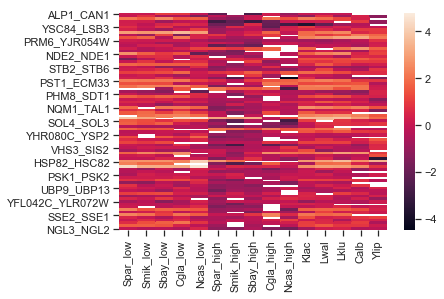

In [49]:
#heatmap prior to clustering, but after filtering wierd species and rows with many NANs

fig_hmap, ax_hmap = plt.subplots()

#Filter out S.Cer because its distribution is so different
#Filter out D.Han because there are so many NANs (probably an indexing problem in the ortholog/expression array set)
raw_expression_data_df_spec_filter = raw_expression_data_df.drop(columns = ['Scer_low', 'Scer_high', 'Dhan'])

#filter out a row if it has Ndrop or more missing orthologs
inds_to_drop = []
Ndrop = 5
for ind, row in enumerate(raw_expression_data_df_spec_filter.values):
     if sum(np.isnan(row)) >= Ndrop:
        inds_to_drop.append(ind)
        
rows_to_drop = raw_expression_data_df_spec_filter.index[inds_to_drop]
print('Dropped the following Paralog Pairs because there were more than ' + str(Ndrop) + ' orthologs missing.')
print(rows_to_drop)
raw_expression_data_df_row_filter = raw_expression_data_df_spec_filter.drop(index=rows_to_drop)


sns.heatmap(raw_expression_data_df_row_filter)

<IPython.core.display.Javascript object>


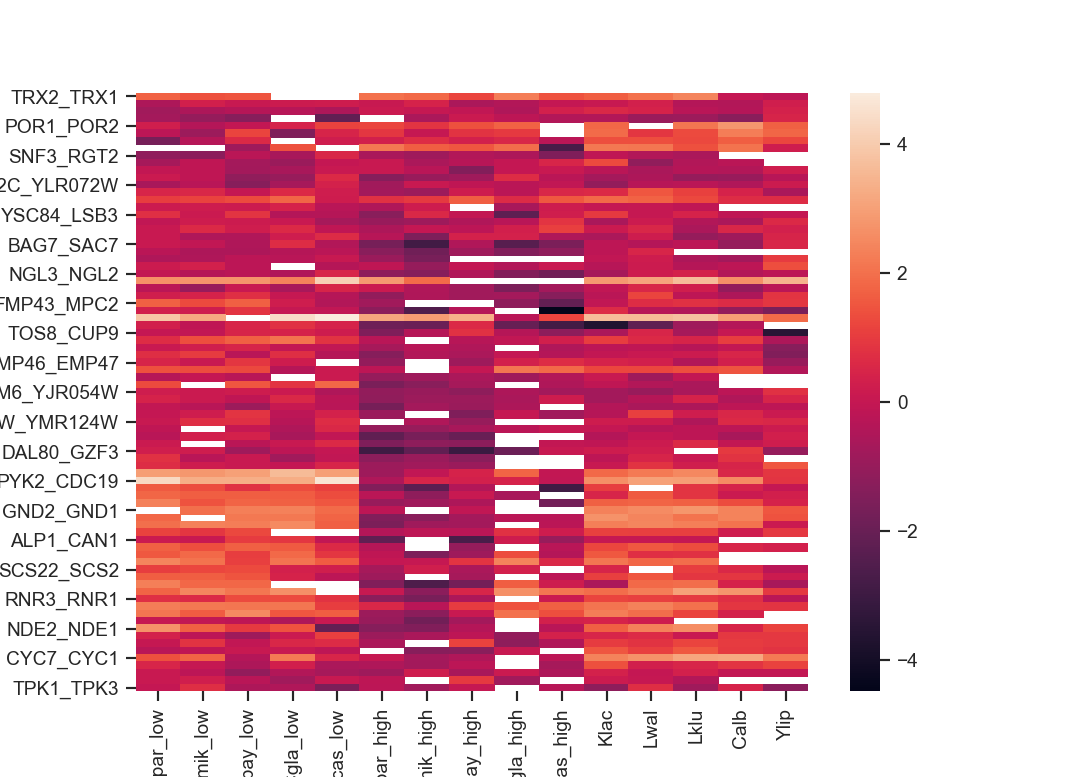

<IPython.core.display.Javascript object>


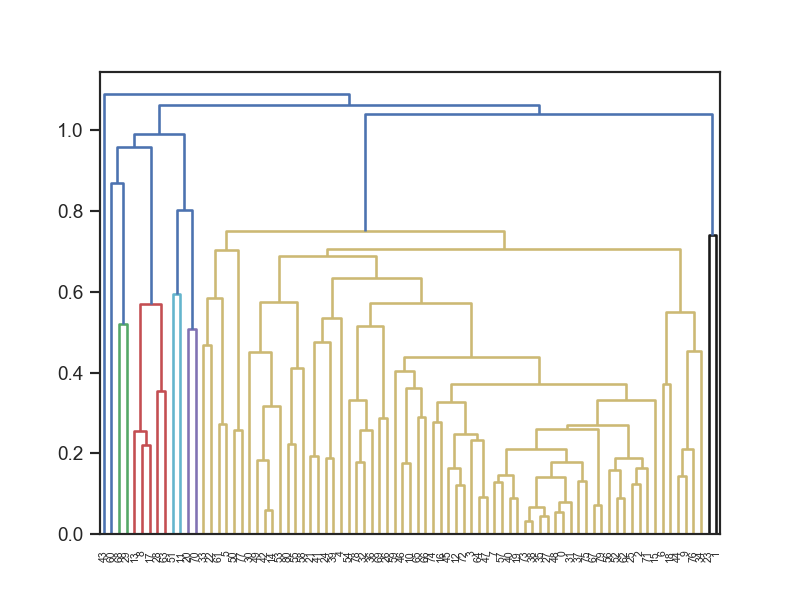

{'icoord': [[25.0, 25.0, 35.0, 35.0],
  [15.0, 15.0, 30.0, 30.0],
  [55.0, 55.0, 65.0, 65.0],
  [45.0, 45.0, 60.0, 60.0],
  [75.0, 75.0, 85.0, 85.0],
  [52.5, 52.5, 80.0, 80.0],
  [22.5, 22.5, 66.25, 66.25],
  [95.0, 95.0, 105.0, 105.0],
  [115.0, 115.0, 125.0, 125.0],
  [100.0, 100.0, 120.0, 120.0],
  [44.375, 44.375, 110.0, 110.0],
  [135.0, 135.0, 145.0, 145.0],
  [155.0, 155.0, 165.0, 165.0],
  [140.0, 140.0, 160.0, 160.0],
  [175.0, 175.0, 185.0, 185.0],
  [150.0, 150.0, 180.0, 180.0],
  [215.0, 215.0, 225.0, 225.0],
  [205.0, 205.0, 220.0, 220.0],
  [212.5, 212.5, 235.0, 235.0],
  [195.0, 195.0, 223.75, 223.75],
  [245.0, 245.0, 255.0, 255.0],
  [250.0, 250.0, 265.0, 265.0],
  [209.375, 209.375, 257.5, 257.5],
  [275.0, 275.0, 285.0, 285.0],
  [295.0, 295.0, 305.0, 305.0],
  [280.0, 280.0, 300.0, 300.0],
  [290.0, 290.0, 315.0, 315.0],
  [335.0, 335.0, 345.0, 345.0],
  [340.0, 340.0, 355.0, 355.0],
  [325.0, 325.0, 347.5, 347.5],
  [365.0, 365.0, 375.0, 375.0],
  [336.25, 336.25,

In [180]:
#Performs heirarchical clustering on filtered data.  Redraws histogram with clusters organized: 

dm = spd.pdist(expression_data_df_row_filter.values, metric = io_library.correlation_nan_filt)
row_cluster = sch.linkage(dm, method='average', optimal_ordering=True)    #might also try 'centroid', 'median', and 'ward'

row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = expression_data_df_row_filter.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

expression_data_df_reorder = expression_data_df_row_filter.reindex(new_rows)


fig_hmfilt, ax_hmfilt = plt.subplots()
sns.heatmap(expression_data_df_reorder, ax=ax_hmfilt)

fig_dend, ax_dend = plt.subplots()
sch.dendrogram(row_cluster, ax=ax_dend)

<IPython.core.display.Javascript object>


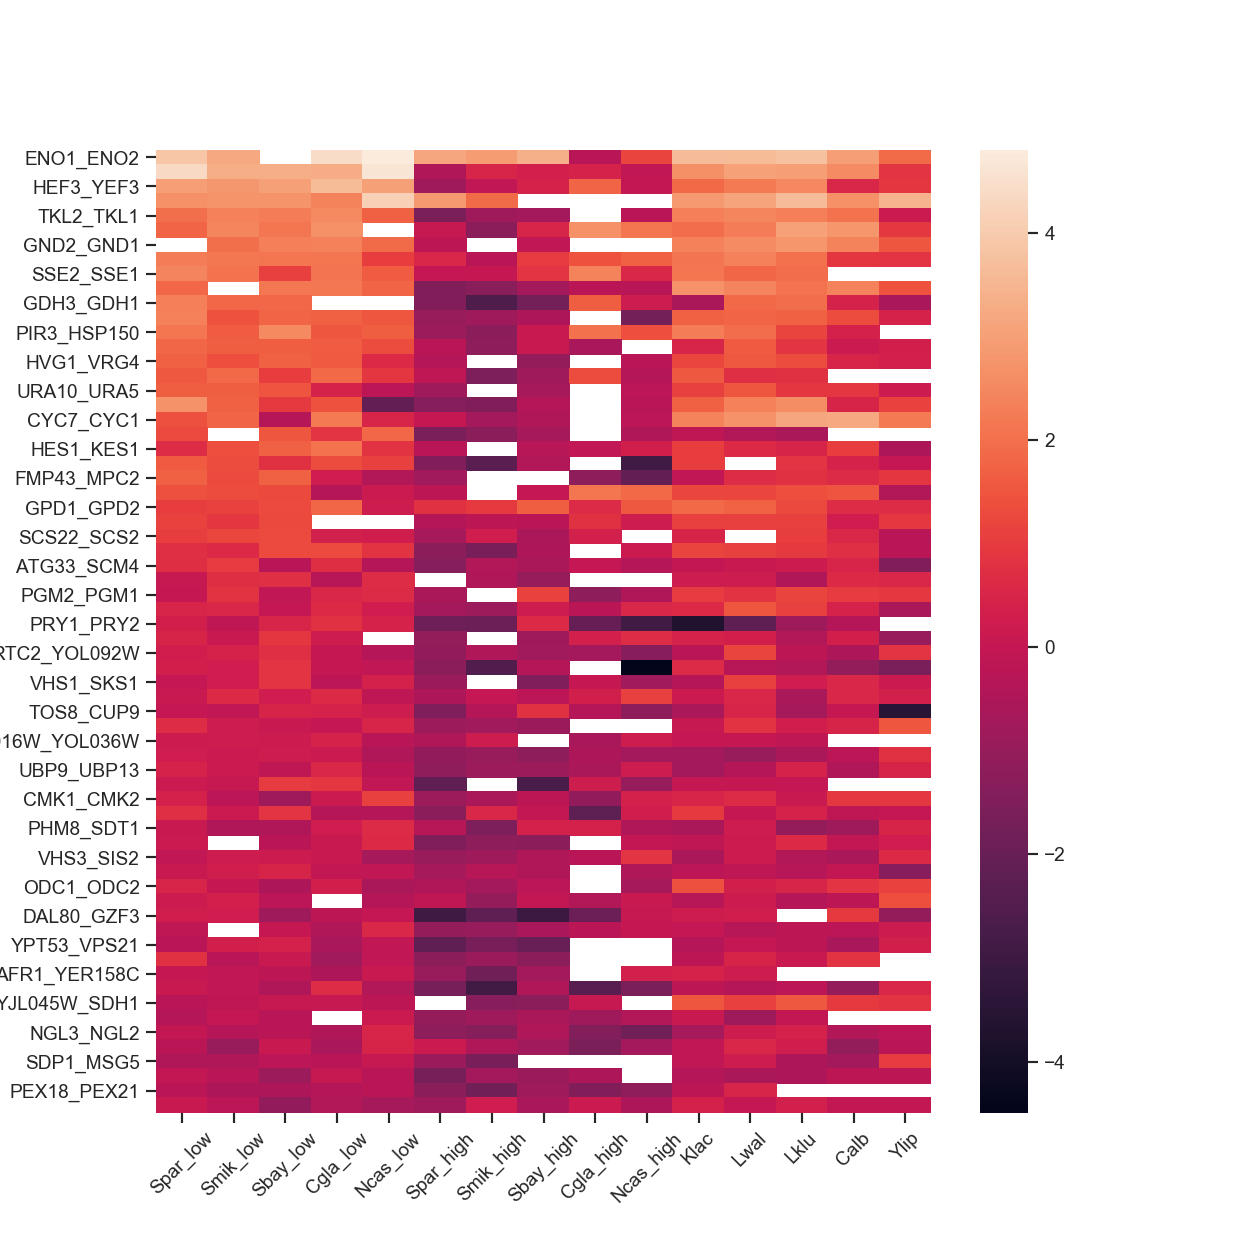

C:\Users\BMH_work\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[Text(0.5,0,'Spar_low'),
 Text(1.5,0,'Smik_low'),
 Text(2.5,0,'Sbay_low'),
 Text(3.5,0,'Cgla_low'),
 Text(4.5,0,'Ncas_low'),
 Text(5.5,0,'Spar_high'),
 Text(6.5,0,'Smik_high'),
 Text(7.5,0,'Sbay_high'),
 Text(8.5,0,'Cgla_high'),
 Text(9.5,0,'Ncas_high'),
 Text(10.5,0,'Klac'),
 Text(11.5,0,'Lwal'),
 Text(12.5,0,'Lklu'),
 Text(13.5,0,'Calb'),
 Text(14.5,0,'Ylip')]

In [184]:
flat_clust = sch.fcluster(row_cluster,1.0, criterion='distance')

fig_clust2, ax_clust2 = plt.subplots(figsize=(10,10))

#pick data from a given cluster
cluster_no = 2
expression_data_clust = expression_data_df_row_filter[flat_clust==cluster_no]

#sort by average of the low columns
cols_to_avg = ['Spar_low', 'Smik_low', 'Sbay_low', 'Cgla_low', 'Ncas_low']
expression_data_clust_subset =  expression_data_clust.loc[:,cols_to_avg]
expression_data_clust['low_median'] = expression_data_clust_subset.median(axis=1)
expression_data_clust_sorted = expression_data_clust.sort_values(by='low_median', ascending=False)
hm = sns.heatmap(expression_data_clust_sorted.drop(columns = 'low_median') , ax=ax_clust2)
hm.set_xticklabels(hm.get_xticklabels(), rotation = 45)

<IPython.core.display.Javascript object>


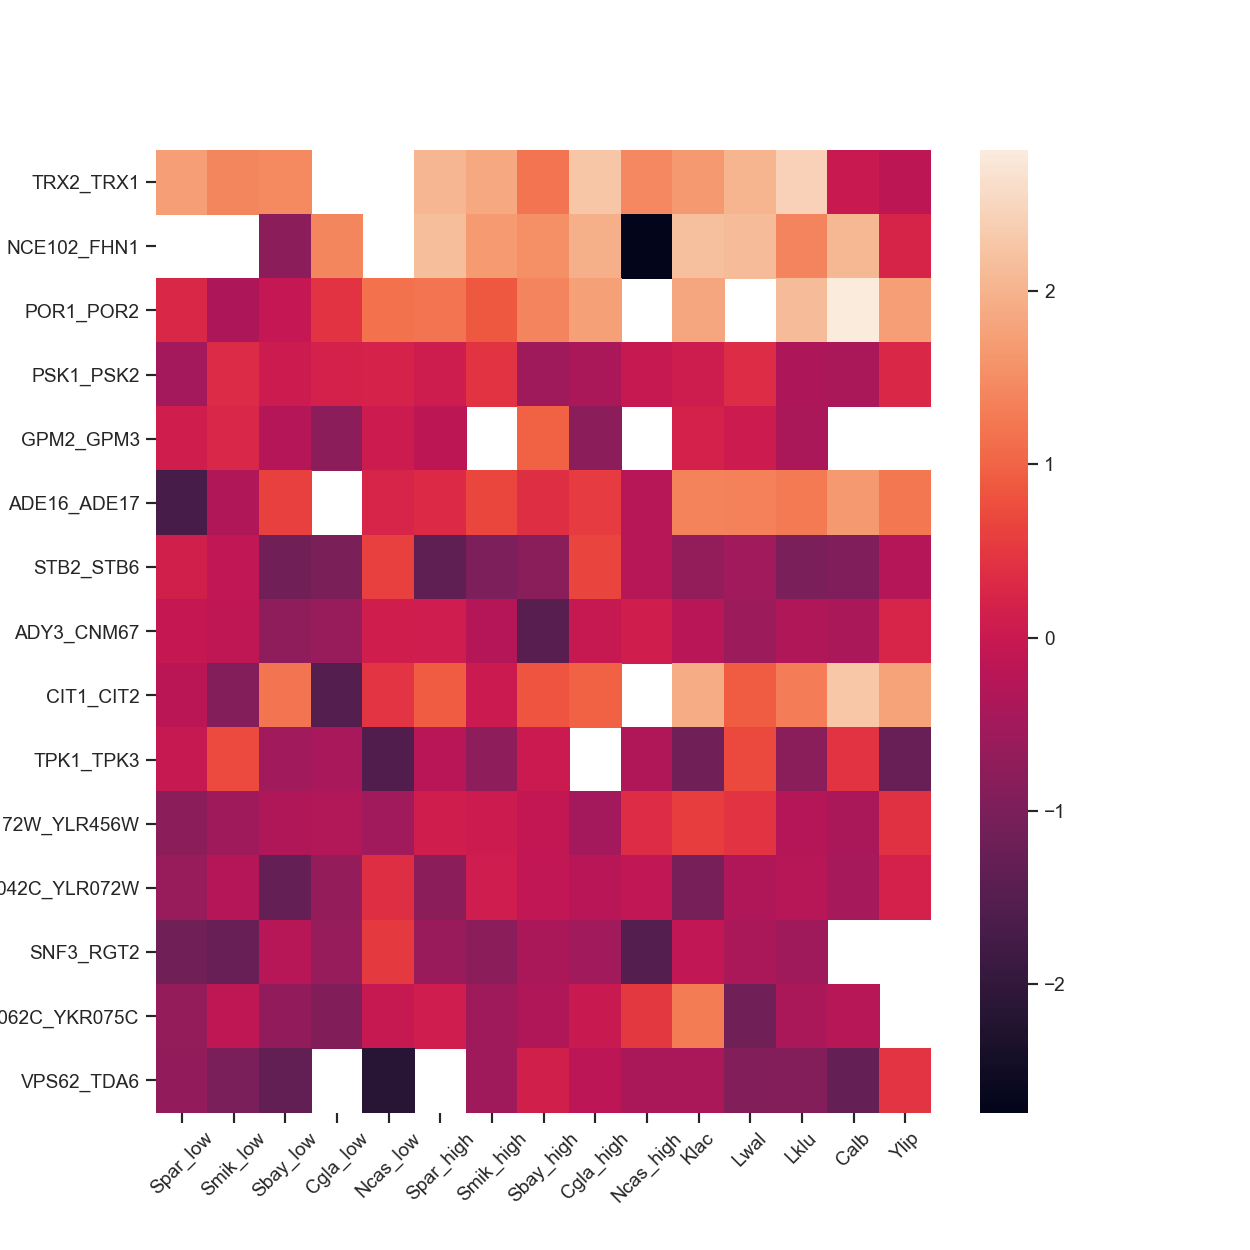

C:\Users\BMH_work\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[Text(0.5,0,'Spar_low'),
 Text(1.5,0,'Smik_low'),
 Text(2.5,0,'Sbay_low'),
 Text(3.5,0,'Cgla_low'),
 Text(4.5,0,'Ncas_low'),
 Text(5.5,0,'Spar_high'),
 Text(6.5,0,'Smik_high'),
 Text(7.5,0,'Sbay_high'),
 Text(8.5,0,'Cgla_high'),
 Text(9.5,0,'Ncas_high'),
 Text(10.5,0,'Klac'),
 Text(11.5,0,'Lwal'),
 Text(12.5,0,'Lklu'),
 Text(13.5,0,'Calb'),
 Text(14.5,0,'Ylip')]

In [198]:
flat_clust = sch.fcluster(row_cluster,1.0, criterion='distance')

fig_clust2, ax_clust2 = plt.subplots(figsize=(10,10))

#all data that is not in cluster 2
expression_data_clust = expression_data_df_row_filter[flat_clust != 2]

#sort by average of the low columns
cols_to_avg = ['Spar_low', 'Smik_low', 'Sbay_low', 'Cgla_low', 'Ncas_low']
expression_data_clust_subset =  expression_data_clust.loc[:,cols_to_avg]
expression_data_clust['low_median'] = expression_data_clust_subset.median(axis=1)
expression_data_clust_sorted = expression_data_clust.sort_values(by='low_median', ascending=False)
hm = sns.heatmap(expression_data_clust_sorted.drop(columns = 'low_median') , ax=ax_clust2)
hm.set_xticklabels(hm.get_xticklabels(), rotation = 45)

In [41]:
#Heirarchical cluster of genes with columns ordered as above to visualise ESR genes. 

#First filter out items with mostly NA values. 
kl_stress_nmpp1_data_filt = kl_stress_nmpp1_data_col_reorder.dropna(thresh=(len(kl_stress_nmpp1_data_col_reorder.columns)-1))

#Drop out PKA column for clustering
kl_stress_data = kl_stress_nmpp1_data_filt.drop('KL_PKA(AS)+1NMPP1', axis = 1)

kl_stress_data_nafill = kl_stress_data.fillna(0.0)
kl_stress_data_mat = kl_stress_data_nafill.as_matrix()

#fig3, ax_cm = plt.subplots()
#ax_cm = sns.clustermap(kl_stress_data_col_reorder_nafill,colcluster = False)
#ax_cm.ax_heatmap.tick_params(labelleft = 'off')

row_cluster = sch.linkage(kl_stress_data_mat, method='average')
row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = kl_stress_nmpp1_data_filt.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

kl_stress_nmpp1_data_filt_reorder = kl_stress_nmpp1_data_filt.reindex(new_rows)

fig3, ax3 = plt.subplots()
#ax3= sns.heatmap(kl_stress_nmpp1_data_filt_reorder)
# ax3 = plt.imshow(kl_stress_nmpp1_data_filt_reorder.as_matrix(), cmap='RdBu', vmin=z_min, vmax=z_max,
#            extent=[x.min(), x.max(), y.min(), y.max()],
#            interpolation='nearest', origin='lower')
ax3 = plt.imshow(-kl_stress_nmpp1_data_filt_reorder.as_matrix(), interpolation="nearest", aspect = 'auto', cmap = 'RdBu',vmin = -6, vmax = 6)
plt.axis('off')
plt.savefig('C:\Users\Ben\Google Drive\UCSF\ElSamad_Lab\Lab Meeting\\20161118\KL_genes.png')


0

# Phylogeny of expression for regev data and GOIs


In [ ]:
#Load Regev data

#merge with goi data
#    Pre -WGH specs

#Visualize 
#    Some singles

#    Cluster
#    when there are two paralogs, pick one


#comparison between regev data and my data



In [309]:
# # Needed to add these other species to the pre-made .csvs
# spec_list = ['Calb', 'Ylip', 'Sjap', 'Spom']
# io_library.make_data_tables(spec_list)

In [63]:
# #Only have to do this once - afterwards can load data from csv

# platform_prefixes = {'Klac': '10499', 'Scer': '9294',
#         'Cgla':'10497', 'Ncas' : '10501', 
#         'Sbay' : '10505', 'Smik': '10502', 
#         'Lwal': '10500', 'Spar': '10496', 
#         'Lklu': '10503', 'Dhan': '15298', 
#         'Vpol': '15297', 'Calb': '10498', 
#         'Ylip': '10495', 'Sjap': '15299',
#         'Spom': '15300' }

# spec_list = ['Scer', 'Klac',  'Cgla', 'Ncas', 'Sbay', 'Suva', 'Smik', 'Lwal', 'Spar', 'Lklu', 'Dhan', 'Vpol', 'Calb',  'Sjap', 'Spom']
# for spec in spec_list: #platform_prefixes.keys(): 
#     io_library.combine_growth_stress_datasets(spec)

C:\Users\BMH_work\github\expression_broad_data\expression_data\regev_data\GSE36253_Growth\Scer_growth.csv growth microarray dataset loaded
C:\Users\BMH_work\github\expression_broad_data\expression_data\regev_data\GSE38478_Stress\Scer_stress.csv stress microarray dataset loaded
Scer has some duplicate spots
combined dataset saved as C:\Users\BMH_work\github\expression_broad_data\expression_data\regev_data\Scer_growth_stress.csv


In [ ]:
#io_library.write_YGOB_orth_lookup_table('Scer', 'Vpol', 'ortholog_files_YGOB/YGOB_Pillars_bmh.txt')

In [3]:
#Order that we view the species (minus S.Cer)
spec_order_post_WGH = ['Spar','Smik', 'Sbay','Suva','Cgla', 'Ncas','Vpol']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']


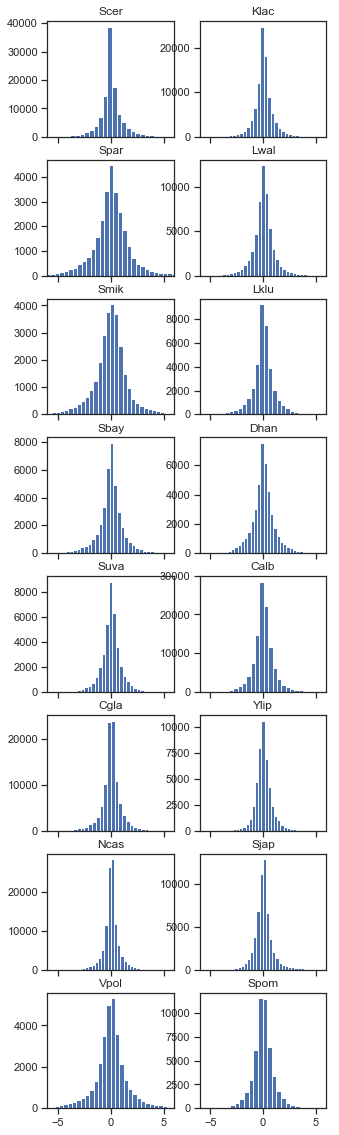

In [4]:
#Look at histogram of all regev data - do I need to do some kind of normalization? 

#Only need to do this once - output is saved as .csv

fig, axarr = plt.subplots(8,2, sharex = True, figsize = (5,20))

spec_sets = {'Post WGH' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

jj = 0
mean_std = {}
for spec_set_name, spec_set in spec_sets.items(): 
    for kk, spec in enumerate(spec_set): 
        ax = axarr[kk,jj]
        fname_array_data = os.path.normpath(data_processing_dir + 'regev_data/' + spec + '_growth_stress.csv')  
        spec_data = pd.read_csv(fname_array_data, index_col=0)
        conditions = spec_data.columns
        all_data_spec = []
        for condition in conditions: 
            all_data_spec = all_data_spec + list(spec_data[condition].dropna())
        ax.hist(all_data_spec, bins=50)
        ax.set_title(spec)
        ax.set_xlim([-6,6])
        mean_std[spec] = {'mean': np.mean(all_data_spec), 'std': np.std(all_data_spec)}
        spec_data_norm = (spec_data - mean_std[spec]['mean'])/(mean_std[spec]['std'])
        fname_array_data_norm = os.path.normpath(data_processing_dir + 'regev_data/' + spec + '_growth_stress_norm.csv')
        spec_data_norm.to_csv(fname_array_data_norm)
        
    jj = jj+1
    



In [4]:
#Load data for all species for a given set of gois

##would be nice to make this into a function - possibly modularizing some of the middle be

## SMIK data often seems to be missing


#Makes dataframe with data for all experiments

orth_dir = data_processing_dir + 'ortholog_files' + os.sep 

columns_to_keep = ['Ancestor']

for level in ['low', 'high']:
    for column_base in ['sc_genename', 'SC_common_name', 'log2FoldChange','pvalue']:
        columns_to_keep.append(column_base + '_' + level)

ohnologs_goi_array = ohnologs_goi_rlog.loc[:,columns_to_keep]

spec_conditions = {}


#adding data just for Scer

spec = 'Scer'

#load data
fname_array_data = os.path.normpath(data_processing_dir + 'regev_data/' + spec + '_growth_stress_norm.csv')  
spec_data = pd.read_csv(fname_array_data, index_col=0)
conditions = spec_data.columns
spec_conditions[spec] = conditions

for level in ['low','high']:
    condition_data_dict = {condition: [] for condition in conditions}
    for gene in ohnologs_goi_array['sc_genename_' + level ]:
        for condition in conditions:
            cond_data = []
            try: 
                cond_data.append(spec_data.loc[gene,condition])
            except KeyError:
                cond_data.append(np.nan)
                print('Mismatch between goi index and expression data index ' + spec + ' : ' + gene + ' ' + condition)
            condition_data_dict[condition].append(cond_data)

    for condition in conditions: 
        ohnologs_goi_array[spec + '_' + condition + '_' + level] = condition_data_dict[condition]



#post WGH:


for spec in spec_order_post_WGH: 

    #load ortholog mapping
    sc_spec_orth_lookup = io_library.read_orth_lookup_table('Scer', spec, orth_dir)

    #load data
    fname_array_data = os.path.normpath(data_processing_dir + 'regev_data/' + spec + '_growth_stress_norm.csv')  
    spec_data = pd.read_csv(fname_array_data, index_col=0)
    conditions = spec_data.columns
    spec_conditions[spec] = conditions

    for level in ['low','high']: 
        N_orth_list = []
        orth_name_list = []
        condition_data_dict = {condition: [] for condition in conditions}
        for gene in ohnologs_goi_array['sc_genename_' + level ]:
            try: 
                if sc_spec_orth_lookup[gene][0]=='NONE':
                    N_orth_list.append(0)
                    orth_name_list.append('NONE_in_orthogroups')
                    for condition in conditions: 
                        condition_data_dict[condition].append(np.nan)
                    print(gene + ' has NONE listed in ortholog file for ' + spec)
                else: 
                    orth_names = sc_spec_orth_lookup[gene]
                    N_orth_list.append(len(orth_names))
                    orth_name_list.append(orth_names)
                    for condition in conditions:
                        cond_data = []
                        for spec_gene in orth_names: 
                            try: 
                                cond_data.append(spec_data.loc[spec_gene,condition])
                            except KeyError:
                                cond_data.append(np.nan)
                                print('Mismatch between ortholog file and expression data index ' + spec + ' : ' + spec_gene + ' ' + condition)
                        condition_data_dict[condition].append(cond_data)
            except KeyError:
                N_orth_list.append(0)
                orth_name_list.append('NONE_not_in_orthogroups')
                for condition in conditions: 
                    condition_data_dict[condition].append(np.nan)
                print(gene + ' not present in orthogroup file for ' + spec)
                
        ohnologs_goi_array[spec + '_N_' + level] = N_orth_list
        ohnologs_goi_array[spec + '_genename_' + level] = orth_name_list
        for condition in conditions: 
            ohnologs_goi_array[spec + '_' + condition + '_' + level] = condition_data_dict[condition]



#pre WGH:


for spec in spec_order_pre_WGH: 

    #load ortholog mapping
    sc_spec_orth_lookup = io_library.read_orth_lookup_table('Scer', spec, orth_dir)

    #load data
    fname_array_data = os.path.normpath(data_processing_dir + 'regev_data/' + spec + '_growth_stress_norm.csv')  
    spec_data = pd.read_csv(fname_array_data, index_col=0)
    conditions = spec_data.columns
    spec_conditions[spec] = conditions

    N_orth_list = []
    orth_name_list = []
    condition_data_dict = {condition: [] for condition in conditions}

    for row in ohnologs_goi_array.loc[:,['sc_genename_low','sc_genename_high']].iterrows():

        gene_low = row[1]['sc_genename_low']
        gene_high = row[1]['sc_genename_high']

        try:         
            if sc_spec_orth_lookup[gene_low] == sc_spec_orth_lookup[gene_high]: 
                gene_to_test = gene_low
                if sc_spec_orth_lookup[gene_to_test][0]=='NONE':
                    N_orth_list.append(0)
                    orth_name_list.append('NONE_in_orthogroups')
                    for condition in conditions: 
                        condition_data_dict[condition].append(np.nan)
                    print(gene_to_test + ' has NONE listed in ortholog file for ' + spec)
                else: 
                    orth_names = sc_spec_orth_lookup[gene_to_test]
                    N_orth_list.append(len(orth_names))
                    orth_name_list.append(orth_names)
                    for condition in conditions:
                        cond_data = []
                        for spec_gene in orth_names:
                            try: 
                                cond_data.append(spec_data.loc[spec_gene,condition])
                            except KeyError:
                                cond_data.append(np.nan)
                                print('Mismatch between ortholog file and expression data index ' + spec + ' : ' + spec_gene + ' ' + condition)
                        condition_data_dict[condition].append(cond_data)

            else: 
                raise LookupError('high and low paralogs do not have same ortholog in ' + spec + ': ' + gene_low + ' and ' + gene_high )
        except KeyError: 
            print('either ' + gene_low + ' or ' + gene_high + 'is not in index for ortholog table in ' + spec)    


            gene_to_test = 'NONE'
            if gene_low in sc_spec_orth_lookup.keys():
                print(gene_low + ' is in index for lookup table')
                gene_to_test = gene_low
            elif gene_high in sc_spec_orth_lookup.keys():
                print(gene_high + ' is in index for lookup table')
                gene_to_test = gene_high

            if gene_to_test != 'NONE':
                print(gene_to_test + ' did have an ortholog in ' + spec)
                if sc_spec_orth_lookup[gene_to_test][0]=='NONE':
                    N_orth_list.append(0)
                    orth_name_list.append('NONE_in_orthogroups')
                    for condition in conditions: 
                        condition_data_dict[condition].append(np.nan)
                    print(gene_to_test + ' has NONE listed in ortholog file for ' + spec)
                else: 
                    orth_names = sc_spec_orth_lookup[gene_to_test]
                    N_orth_list.append(len(orth_names))
                    orth_name_list.append(orth_names)
                    for condition in conditions:
                        cond_data = []
                        for spec_gene in orth_names:
                            try: 
                                cond_data.append(spec_data.loc[spec_gene,condition])
                            except KeyError:
                                cond_data.append(np.nan)
                                print('Mismatch between ortholog file and expression data index ' + spec + ' : ' + spec_gene + ' ' + condition)
                        condition_data_dict[condition].append(cond_data)
            else:
                raise RuntimeError('Neither gene is index for ortholog table, but it was not caught in the first section')


    ohnologs_goi_array[spec + '_N'] = N_orth_list
    ohnologs_goi_array[spec + '_genename'] = orth_name_list
    for condition in conditions: 
        ohnologs_goi_array[spec + '_' + condition] = condition_data_dict[condition]




Mismatch between goi index and expression data index Scer : YDR524C-B DS/LOG
Mismatch between goi index and expression data index Scer : YDR524C-B LAG/LOG
Mismatch between goi index and expression data index Scer : YDR524C-B LL/LOG
Mismatch between goi index and expression data index Scer : YDR524C-B PLAT/LOG
Mismatch between goi index and expression data index Scer : YDR524C-B PS/LOG
Mismatch between goi index and expression data index Scer : YDR524C-B NaCl_005
Mismatch between goi index and expression data index Scer : YDR524C-B NaCl_015
Mismatch between goi index and expression data index Scer : YDR524C-B NaCl_030
Mismatch between goi index and expression data index Scer : YDR524C-B NaCl_060
Mismatch between goi index and expression data index Scer : YDR524C-B heat shock_005
Mismatch between goi index and expression data index Scer : YDR524C-B heat shock_015
Mismatch between goi index and expression data index Scer : YDR524C-B heat shock_030
Mismatch between goi index and expression

YLR080W has NONE listed in ortholog file for Smik
YDR247W has NONE listed in ortholog file for Smik
YOR237W has NONE listed in ortholog file for Smik
YMR271C has NONE listed in ortholog file for Smik
YBR056W-A not present in orthogroup file for Sbay
YHR174W has NONE listed in ortholog file for Sbay
YCR075W-A has NONE listed in ortholog file for Sbay
YIL113W has NONE listed in ortholog file for Sbay
YDR034W-B has NONE listed in ortholog file for Sbay
YGR243W has NONE listed in ortholog file for Sbay
YDR342C has NONE listed in ortholog file for Sbay
YOR186W has NONE listed in ortholog file for Sbay
YPL240C has NONE listed in ortholog file for Sbay
YIR016W has NONE listed in ortholog file for Sbay
YBR056W-A not present in orthogroup file for Suva
YHR174W has NONE listed in ortholog file for Suva
YCR075W-A has NONE listed in ortholog file for Suva
YIL113W has NONE listed in ortholog file for Suva
YDR034W-B has NONE listed in ortholog file for Suva
YGR243W has NONE listed in ortholog file f

YDR524C-B not present in orthogroup file for Ncas
YNL052W not present in orthogroup file for Ncas
YBR056W-A not present in orthogroup file for Ncas
YGR131W not present in orthogroup file for Ncas
YLR043C not present in orthogroup file for Ncas
YHR108W not present in orthogroup file for Ncas
YLR293C not present in orthogroup file for Ncas
YLR297W not present in orthogroup file for Ncas
YOR375C not present in orthogroup file for Ncas
YFL048C not present in orthogroup file for Ncas
YCL048W-A not present in orthogroup file for Ncas
YNR001C not present in orthogroup file for Ncas
YNL093W not present in orthogroup file for Ncas
YNL055C not present in orthogroup file for Ncas
YIL113W not present in orthogroup file for Ncas
YLR031W not present in orthogroup file for Ncas
YKL091C not present in orthogroup file for Ncas
YDL021W not present in orthogroup file for Ncas
YDR034W-B not present in orthogroup file for Ncas
YLR346C not present in orthogroup file for Ncas
YGR256W not present in orthogrou

YDR524C-B has NONE listed in ortholog file for Klac
either YBR056W-A or YDR034W-Bis not in index for ortholog table in Klac
YDR034W-B is in index for lookup table
YDR034W-B did have an ortholog in Klac
YGR035C has NONE listed in ortholog file for Klac
YGR169C-A has NONE listed in ortholog file for Klac
YLR297W has NONE listed in ortholog file for Klac
YCR075W-A has NONE listed in ortholog file for Klac
YPL130W has NONE listed in ortholog file for Klac
YDR524C-B has NONE listed in ortholog file for Lwal
YIL114C has NONE listed in ortholog file for Lwal
YNL052W has NONE listed in ortholog file for Lwal
either YBR056W-A or YDR034W-Bis not in index for ortholog table in Lwal
YDR034W-B is in index for lookup table
YDR034W-B did have an ortholog in Lwal
YDR034W-B has NONE listed in ortholog file for Lwal
YGR035C has NONE listed in ortholog file for Lwal
YHR163W has NONE listed in ortholog file for Lwal
YGR169C-A has NONE listed in ortholog file for Lwal
YLR297W has NONE listed in ortholog fi

YDR524C-B has NONE listed in ortholog file for Calb
YEL063C has NONE listed in ortholog file for Calb
YOL056W has NONE listed in ortholog file for Calb
either YBR056W-A or YDR034W-Bis not in index for ortholog table in Calb
YDR034W-B is in index for lookup table
YDR034W-B did have an ortholog in Calb
YDR034W-B has NONE listed in ortholog file for Calb
YGR035C has NONE listed in ortholog file for Calb
YLR413W has NONE listed in ortholog file for Calb
YGR239C has NONE listed in ortholog file for Calb
YHR092C has NONE listed in ortholog file for Calb
YDR345C has NONE listed in ortholog file for Calb
YLR297W has NONE listed in ortholog file for Calb
YMR182C has NONE listed in ortholog file for Calb
YCR075W-A has NONE listed in ortholog file for Calb
YOR324C has NONE listed in ortholog file for Calb
YOL036W has NONE listed in ortholog file for Calb
YDL138W has NONE listed in ortholog file for Calb
YER158C has NONE listed in ortholog file for Calb
YPL106C has NONE listed in ortholog file for

In [6]:
spec_conditions

{'Scer': Index(['DS/LOG', 'LAG/LOG', 'LL/LOG', 'PLAT/LOG', 'PS/LOG', 'NaCl_005',
        'NaCl_015', 'NaCl_030', 'NaCl_060', 'heat shock_005', 'heat shock_015',
        'heat shock_030', 'heat shock_045', 'heat shock_060',
        'hydrogen peroxide_005', 'hydrogen peroxide_015',
        'hydrogen peroxide_030', 'hydrogen peroxide_060'],
       dtype='object'),
 'Spar': Index(['DS/LOG', 'LAG/LOG', 'LPS/LOG', 'PLAT/LOG', 'PS/LOG'], dtype='object'),
 'Smik': Index(['DS/LOG', 'LAG/LOG', 'LL/LOG', 'PLAT/LOG', 'PS/LOG'], dtype='object'),
 'Sbay': Index(['DS/LOG', 'ELL/LOG', 'LAG/LOG', 'LL/LOG', 'LPS/LOG', 'PLAT/LOG',
        'PS/LOG'],
       dtype='object'),
 'Suva': Index(['DS/LOG', 'EPS/LOG', 'LAG/LOG', 'LL/LOG', 'LPS/LOG', 'PLAT/LOG',
        'PS/LOG'],
       dtype='object'),
 'Cgla': Index(['DS/LOG', 'ELL/LOG', 'LAG/LOG', 'LL/LOG', 'PLAT/LOG', 'PS/LOG',
        'NaCl_005', 'NaCl_015', 'NaCl_030', 'NaCl_060', 'heat shock_005',
        'heat shock_015', 'heat shock_030', 'heat shock_045

In [7]:
list(ohnologs_goi_array['SC_common_name_high'])

['YCL048W-A',
 'ALP1',
 'TPK1',
 'PIR3',
 'DAL80',
 'PRY1',
 'YSC84',
 'CMK1',
 'HEF3',
 'CIT1',
 'CYC7',
 'PRM6',
 'ADY3',
 'YPT53',
 'POR1',
 'SDP1',
 'COX5B',
 'NDE2',
 'YLR031W',
 'ADE16',
 'PGM2',
 'YKL091C',
 'STB2',
 'RTC2',
 'GPD1',
 'GPM2',
 'YDR018C',
 'YDR034W-B',
 'PST1',
 'UBC5',
 'TKL2',
 'NCE102',
 'VPS62',
 'PHM8',
 'HVG1',
 'SAP4',
 'VMR1',
 'PEX30',
 'YLR346C',
 'NQM1',
 'ATG33',
 'YKL187C',
 'GND2',
 'ENO1',
 'SOL4',
 'FMP43',
 'PEX18',
 'TRX2',
 'YJR005C-A',
 'YJL045W',
 'YHR080C',
 'HXT7',
 'HXT5',
 'YHR097C',
 'GGA1',
 'BAG7',
 'VHS3',
 'YOR062C',
 'GSP2',
 'YOR186W',
 'SDS24',
 'TOS8',
 'USV1',
 'HSP82',
 'YNR034W-A',
 'GDH3',
 'PYK2',
 'FUN19',
 'FRT2',
 'PSK1',
 'YIR016W',
 'RNR3',
 'SNF3',
 'SHC1',
 'UBP9',
 'AVT6',
 'SCS22',
 'YPR172W',
 'EMP46',
 'YFL042C',
 'AFR1',
 'CRF1',
 'RTN2',
 'VHS1',
 'SSE2',
 'YOR214C',
 'ODC1',
 'HER1',
 'HES1',
 'URA10',
 'NGL3']

Text(0.5,0.98,'MPC2 FMP43')

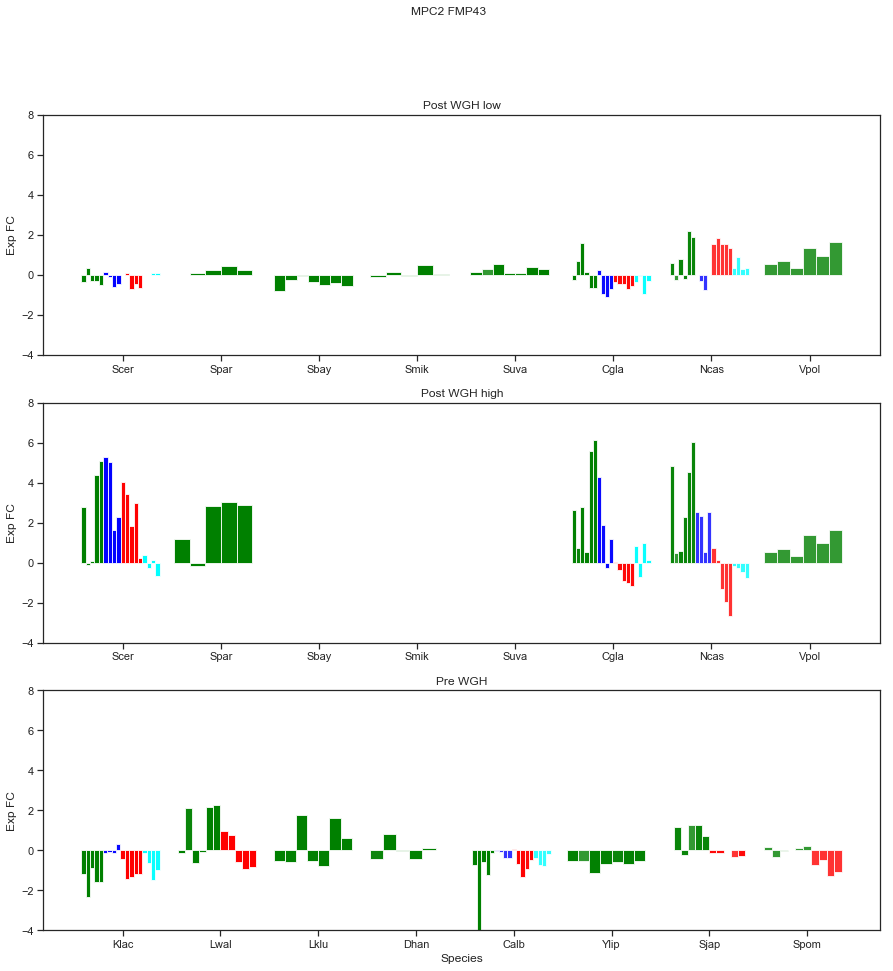

In [12]:
#For a given high_gene, plot expression across all conditions for all its orthologs

#Plot it in three subplots - high, low, pre_wgh

high_gene = 'FMP43'
row = ohnologs_goi_array[ohnologs_goi_array['SC_common_name_high']==high_gene]

fig, axarr = plt.subplots(3,1, figsize = (15,15))
spec_frac = 0.8  #fraction of distance between 1 and the next number a species takes up
opacity = 0.8

# spec_order_post_WGH = ['Spar','Sbay','Smik','Suva', 'Cgla', 'Ncas','Vpol']
# spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 


levels = {'Post WGH low': 'low', 
          'Post WGH high': 'high', 
          'Pre WGH' : ''}

for kk, spec_set_name in enumerate(spec_sets.keys()):
    
    ax = axarr[kk]
    level = levels[spec_set_name]
    spec_set = spec_sets[spec_set_name]
    
    if level == '': 
        level_sep = ''
    else: 
        level_sep = '_'

    #Build dicts to store data from all possible conditions that we want to consider

    #all_conds = list(set(list(chain.from_iterable([list(conditions) for spec, conditions in spec_conditions.items()]))))

    #this puts it in a better order
    all_conds = ['LAG/LOG','LL/LOG','ELL/LOG','DS/LOG','EPS/LOG','PS/LOG','LPS/LOG','PLAT/LOG',
     'NaCl_005',
     'NaCl_015',
     'NaCl_030',
     'NaCl_060', 
     'heat shock_005',
     'heat shock_015',
     'heat shock_030',
     'heat shock_045',
     'heat shock_060',
     'hydrogen peroxide_005',
     'hydrogen peroxide_015',
     'hydrogen peroxide_030',
     'hydrogen peroxide_060']

    #Build colordict to separate conditions
    colors = {}
    for condition in all_conds: 
        if ("/" in condition):
            colors[condition] = 'green'
        elif('heat shock' in condition):
            colors[condition] = 'red'
        elif('NaCl' in condition): 
            colors[condition] = 'blue'
        elif('hydrogen peroxide' in condition): 
            colors[condition] = 'cyan'

    index = {condition : [] for condition in all_conds} 
    bar_width = {condition : [] for condition in all_conds}
    data = {condition : [] for condition in all_conds}   


    for spec_ind, spec in enumerate(spec_set): 
        #If S.Cer always only one orth.  
        if spec== 'Scer': 
            N_orth = 1
        else: 
            N_orth = row[spec + '_N' + level_sep + level].iloc[0]

        conditions = spec_conditions[spec]
        N_cond = len(conditions)

        if N_orth==0:
            dw = spec_frac/N_cond
        else: 
            dw = spec_frac/(N_cond*N_orth)

        for condition_ind, condition in enumerate(conditions): 
            #append data for each condition to the set of bars to be plotted

            if N_orth ==0:
                index[condition].append(spec_ind + dw*condition_ind)
                bar_width[condition].append(dw)
                data[condition].append(np.nan)
            else: 
                for jj in range(0,N_orth): 
                    index[condition].append(spec_ind + dw*condition_ind + jj*dw/N_cond)
                    bar_width[condition].append(dw/N_orth)
                    data[condition].append(row[spec + '_' + condition + level_sep + level].values[0][jj])


            rects_pre_WGH = ax.bar(index[condition], np.array(data[condition]), bar_width[condition],
                             alpha=opacity,
                             color=colors[condition],
                             label=condition) 
                             #bottom = bottom)

    if kk==2: 
        ax.set_xlabel('Species')
    ax.set_ylabel('Exp FC')
    ax.set_ylim(-4,8)
    ax.set_title(spec_set_name)
    ax.set_xticks(np.arange(len(spec_set))+spec_frac/2.0)
    ax.set_xticklabels(spec_set)

fig.suptitle(row['SC_common_name_low'].values[0] + ' ' +  row['SC_common_name_high'].values[0])



In [15]:
fig.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/MPC23.svg'))

In [5]:
#Go through each of my GOIs and replace lists with single value for each item. 
#This is mainly to combine any values for genes that had a small scale duplication. 

# spec_order_post_WGH = ['Spar','Sbay','Smik','Suva', 'Cgla', 'Ncas','Vpol']
# spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

expression_data_df = io_library.regev_ohnolog_expression_data_SSD_combine(ohnologs_goi_array,  spec_sets, spec_conditions, combine_method = 'mean')


In [6]:
# Organize species conditions by a given vector of all possible conditions

all_conds = ['LAG/LOG','LL/LOG','ELL/LOG','DS/LOG','EPS/LOG','PS/LOG','LPS/LOG','PLAT/LOG',
     'NaCl_005',
     'NaCl_015',
     'NaCl_030',
     'NaCl_060', 
     'heat shock_005',
     'heat shock_015',
     'heat shock_030',
     'heat shock_045',
     'heat shock_060',
     'hydrogen peroxide_005',
     'hydrogen peroxide_015',
     'hydrogen peroxide_030',
     'hydrogen peroxide_060']

spec_order_post_WGH = ['Spar','Sbay','Smik','Suva', 'Cgla', 'Ncas','Vpol']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 


levels = {'Post WGH low': 'low', 
          'Post WGH high': 'high', 
          'Pre WGH' : ''}

new_col_order = []
for spec_set_name, spec_set in spec_sets.items():
    level = levels[spec_set_name]
    if level == '': 
        level_sep = ''
    else: 
        level_sep = '_'

    for spec in spec_set:    

        if level_sep == '':
            columns_spec = [column for column in expression_data_df.columns if 
             (column.split('_')[0]==spec)]
        else: 
            columns_spec = [column for column in expression_data_df.columns if 
             (column.split('_')[0]==spec) and 
             (column.split('_')[-1]==level)]

        columns_spec_sorted = []
        for cond in all_conds: 
            cond_spec = spec + '_' + cond + level_sep + level
            if cond_spec in columns_spec: 
                columns_spec_sorted.append(cond_spec)

        new_col_order = new_col_order + columns_spec_sorted

#Save the new_col_order for later
#expression_data_df_col_sort = expression_data_df.loc[:,new_col_order]

#Sort dataset by how long high expression is retained in the high paralog in post WGH high gene
#filter out a row if it has Ndrop or more missing orthologs
inds_to_drop = []
Ndrop = 130
for ind, row in enumerate(expression_data_df.values):
    if sum(np.isnan(row)) >= Ndrop:
        inds_to_drop.append(ind)
        
rows_to_drop = expression_data_df.index[inds_to_drop]
print('Dropped the following Paralog Pairs because there were more than ' + str(Ndrop) + ' orthologs missing.')
print(rows_to_drop)
expression_data_df_row_filter = expression_data_df.drop(index=rows_to_drop)


#Sort out rows by whether the averaged "PKAest" or PKA estimate columns are above a threshold.  
#Sort by the species farthes from S.Cer first (so top row will be most conserved)

columns_to_combine = {'PS/LOG', 'PLAT/LOG', 'DS/LOG', 'heat shock_30', 'heat shock_45'}
    
    
#threshold for induction using the average of the combined columns that make up the PKA inhibition estimate.  
#All data is normalized already
induced_thresh = 1.5
    
#Make a column which is average fold change for these columns
for spec in ['Scer'] + spec_order_post_WGH: 
    columns_to_combine_spec = [column for column in expression_data_df_row_filter.columns if 
     (column.split('_')[0]==spec) and 
     (column.split('_')[1] in columns_to_combine) and
     (column.split('_')[2]=='high')]
    expression_data_df_row_filter[spec + '_PKAest_high'] = expression_data_df_row_filter.loc[:,columns_to_combine_spec].apply(np.mean, axis = 1)
    expression_data_df_row_filter[spec + '_PKAestInd_high'] = (expression_data_df_row_filter[spec + '_PKAest_high']>induced_thresh)
        
expression_data_df_sorted = expression_data_df_row_filter.sort_values(by=[spec + '_PKAestInd_high' for spec in reversed(spec_sets['Post WGH high'])], ascending=False)

#add back in the new column order and drop out the extra columns that were added
expression_data_df_sorted = expression_data_df_sorted.loc[:,new_col_order]
expression_data_df_sorted

Dropped the following Paralog Pairs because there were more than 130 orthologs missing.
Index(['YCL048W-A_YDR524C-B', 'YDR034W-B_YBR056W-A', 'YLR346C_YGR035C',
       'YOR186W_YLR297W', 'YNR034W-A_YCR075W-A'],
      dtype='object')


,Scer_LAG/LOG_low,Scer_LL/LOG_low,Scer_DS/LOG_low,Scer_PS/LOG_low,Scer_PLAT/LOG_low,Scer_NaCl_005_low,Scer_NaCl_015_low,Scer_NaCl_030_low,Scer_NaCl_060_low,Scer_heat shock_005_low,...,Spom_LAG/LOG,Spom_LL/LOG,Spom_ELL/LOG,Spom_DS/LOG,Spom_PS/LOG,Spom_PLAT/LOG,Spom_heat shock_005,Spom_heat shock_015,Spom_heat shock_030,Spom_heat shock_060
PHM8_SDT1,0.114367,0.811837,0.121256,-0.478448,-0.593352,-0.049588,-0.060905,0.189545,0.849256,0.116155,...,-0.432100,1.620747,0.708767,1.740109,1.824968,1.753064,0.089721,0.717285,0.426800,-0.077110
PEX18_PEX21,1.704635,0.121182,0.229398,1.079455,1.255789,0.125256,-0.359411,-0.824248,-0.248648,-0.071480,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
TOS8_CUP9,-0.792731,0.790199,0.547303,0.809193,1.030379,0.005330,0.374116,0.466118,0.950716,0.516395,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
CIT1_CIT2,1.589396,-0.014506,0.253825,1.554584,5.419031,-0.050891,0.295293,0.040527,0.029164,1.150890,...,-1.154993,3.109500,1.501565,3.325292,3.637722,3.689549,0.260587,0.889814,0.265158,-0.758531
YJL045W_SDH1,-2.286183,1.371912,2.425067,3.654732,4.054331,0.062841,0.785866,1.045541,1.161266,0.410394,...,0.203880,1.973529,0.910258,2.102147,2.194975,2.591145,0.024937,-0.038984,-0.162644,-0.403774
HXT5_HXT3,-0.879824,-1.053278,-3.194898,-4.188050,-3.327052,0.311757,-1.330598,-1.851293,-0.737066,-0.529465,...,-0.361889,1.553167,1.217325,1.593206,1.670377,1.408259,0.293390,-0.254039,-0.854855,-0.599415
TKL2_TKL1,-0.172685,-0.016498,-0.563992,-3.143804,-2.241886,-0.000246,-0.039176,-0.196417,-0.182772,-0.158653,...,-0.414924,0.669712,0.164306,0.815302,0.881386,0.868891,-0.256496,-0.015918,0.034865,-0.186475
YDR018C_CST26,-0.334484,-0.284856,-0.532945,-1.428550,-1.160796,-0.388764,-1.040176,-0.421319,-0.703913,-0.245356,...,-0.351894,-0.798956,-0.467964,-0.812772,-0.882568,-0.831009,-0.383907,-0.446413,-0.376620,-0.279779
FUN19_YOR338W,6.534410,-1.545855,-0.245819,1.020116,1.128672,0.042722,-0.268051,-0.125756,-0.751617,-0.266851,...,0.227639,-1.056614,-0.555745,-1.061222,-0.970228,-0.976973,-0.630311,-1.199820,-1.139128,-0.519054
SNF3_RGT2,1.428164,-0.464934,-0.495113,-0.237487,0.170123,-0.581253,0.190365,0.072214,-0.453228,-0.173945,...,-0.361889,1.553167,1.217325,1.593206,1.670377,1.408259,0.293390,-0.254039,-0.854855,-0.599415


In [11]:
expression_data_df_sorted.to_csv(os.path.normpath(data_processing_dir + 'regev_data/20190117_expression_data_sorted.csv'))

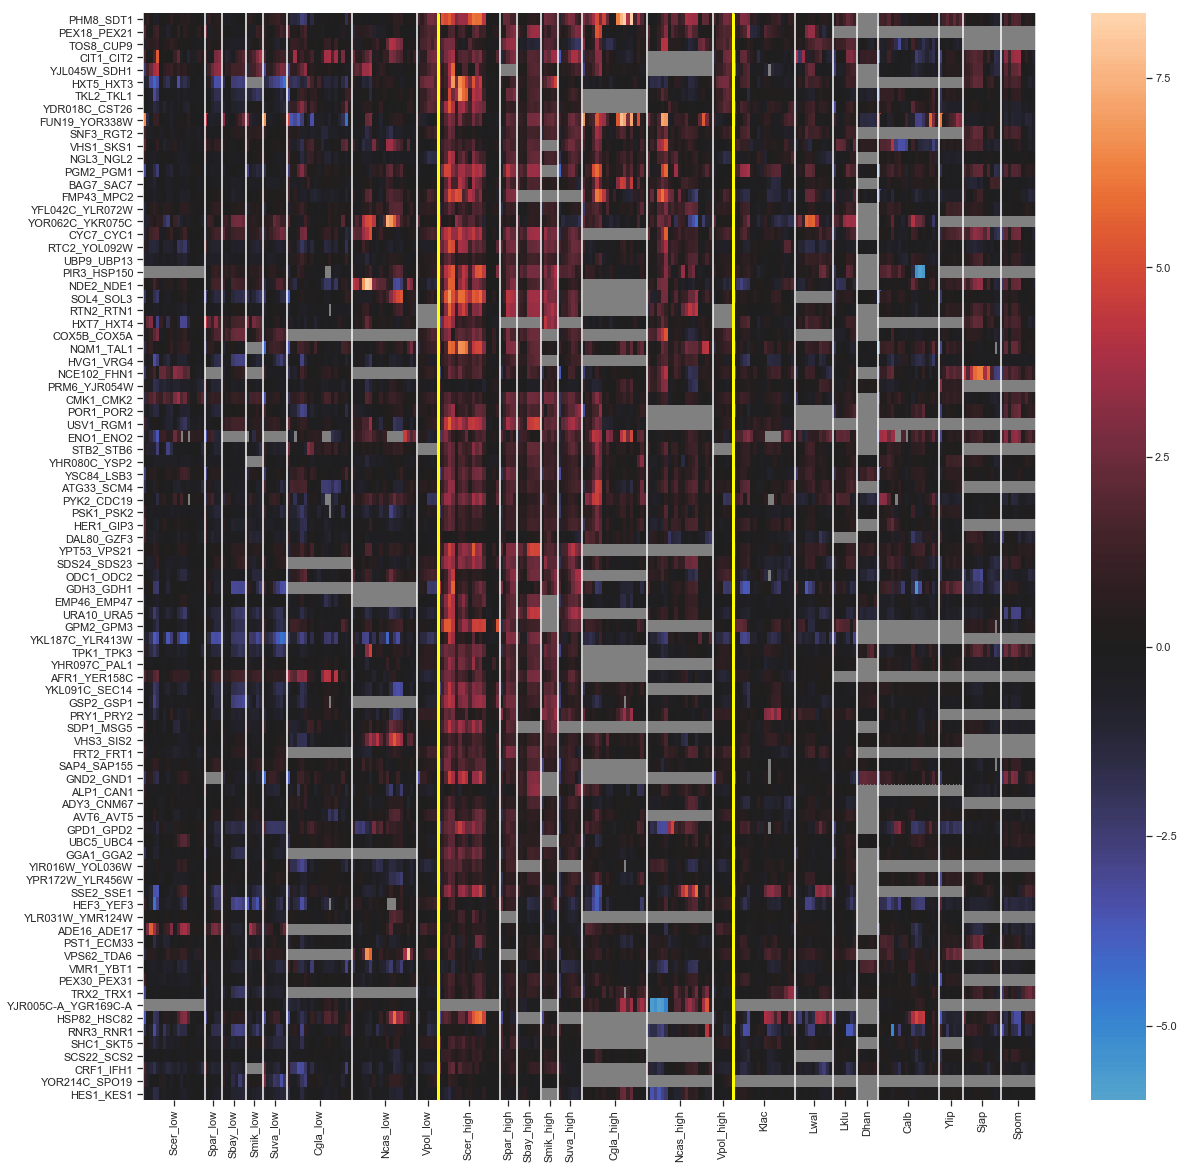

In [8]:
#heatmap after filtering and sorting - all conditions

fig_hmap_exp, ax_hmap_exp = plt.subplots(figsize=(20,20))


#Make labels for each species, and separate out pre/post WGH and post WGH high/low with yellow lines
N_spec_level = {}

label_order = []
for level in ['low','high']:
    for spec in spec_sets['Post WGH ' + level]:
        label = spec + '_' + level
        N_spec_level[label] = 0
        label_order.append(label)
for spec in spec_sets['Pre WGH']: 
    label = spec
    N_spec_level[label] = 0 
    label_order.append(label)


for column in expression_data_df_sorted.columns: 
    spec = column.split('_')[0]
    if spec in set(spec_sets['Post WGH low']):
        level_sep = '_'
        level = column.split('_')[-1]
    else: 
        level_sep = ''
        level = ''
    label = spec + level_sep + level
    N_spec_level[label] = N_spec_level[label] + 1
    
new_ticks = []
sep_lines = [0]
new_tick_labels = []
big_lines = []
tick_tracker = 0
for label in label_order:
    N_tick_dist = N_spec_level[label]
    new_ticks.append(tick_tracker + N_tick_dist/2)
    new_tick_labels.append(label)
    sep_lines.append(tick_tracker + N_tick_dist)
    #new_tick_labels.append('')
    tick_tracker = tick_tracker + N_tick_dist
    if label in {'Vpol_low', 'Vpol_high'}:
        big_lines.append(tick_tracker)



sns.heatmap(expression_data_df_sorted, center = 0.0, xticklabels=False, ax = ax_hmap_exp)
ax_hmap_exp.set_facecolor('grey')
ax_hmap_exp.set_xticks(new_ticks)
ax_hmap_exp.set_xticklabels(new_tick_labels, rotation = 90)  #rotation=45, ha='right')
ax_hmap_exp.vlines(sep_lines, ymin = 0, ymax = len(expression_data_df_sorted), colors = 'white')
ax_hmap_exp.vlines(big_lines, ymin = 0, ymax = len(expression_data_df_sorted), colors = 'yellow',linewidth=3)
ax_hmap_exp.set_rasterized(True)    #Had to do this because .svg took ages on inkscape to work with
fig_hmap_exp.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/exp_goi_regev.svg'))

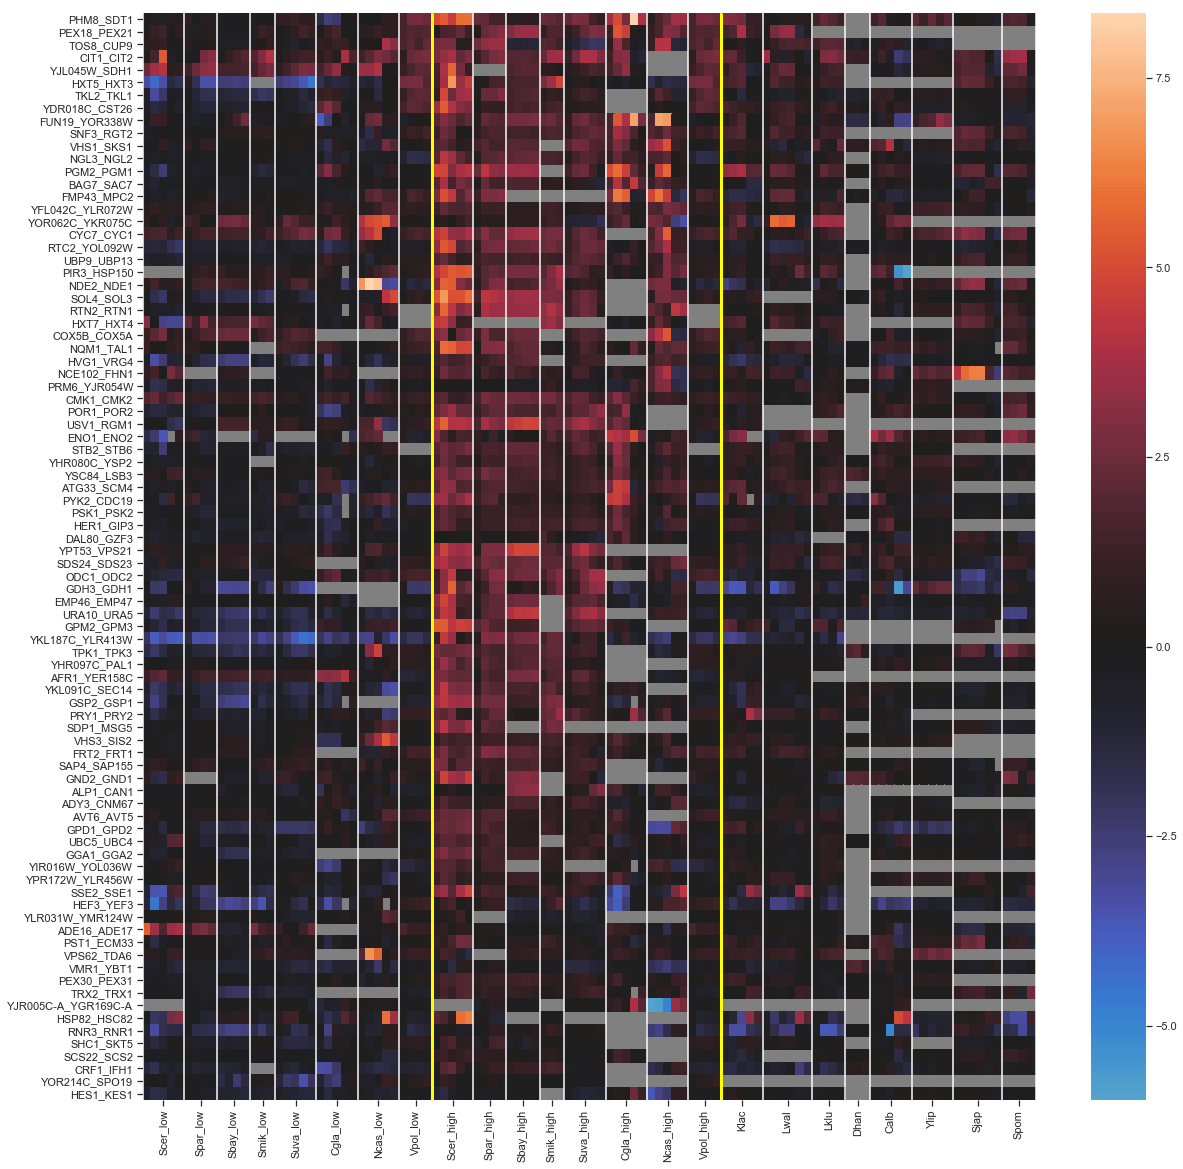

In [25]:
#heatmap after filtering and sorting - just top PKA conditions

fig_hmap_exp, ax_hmap_exp = plt.subplots(figsize=(20,20))

#Make subset that only has columns with appropriate conditions:
columns_pka_corr = ['DS/LOG', 'PS/LOG', 'PLAT/LOG',
                    'heat shock_030', 'heat shock_045']

new_columns = []
for column in expression_data_df_sorted.columns: 
    pass_test = False
    for cond in conds_pka_corr:
        if cond in column: 
            pass_test=True

    if pass_test:
        new_columns.append(column)
        
expression_data_df_pka_corr = expression_data_df_sorted.loc[:,new_columns]    
   

#Make labels for each species, and separate out pre/post WGH and post WGH high/low with yellow lines
N_spec_level = {}

label_order = []
for level in ['low','high']:
    for spec in spec_sets['Post WGH ' + level]:
        label = spec + '_' + level
        N_spec_level[label] = 0
        label_order.append(label)
for spec in spec_sets['Pre WGH']: 
    label = spec
    N_spec_level[label] = 0 
    label_order.append(label)


for column in expression_data_df_pka_corr.columns: 
    spec = column.split('_')[0]
    if spec in set(spec_sets['Post WGH low']):
        level_sep = '_'
        level = column.split('_')[-1]
    else: 
        level_sep = ''
        level = ''
    label = spec + level_sep + level
    N_spec_level[label] = N_spec_level[label] + 1
    
new_ticks = []
sep_lines = [0]
new_tick_labels = []
big_lines = []
tick_tracker = 0
for label in label_order:
    N_tick_dist = N_spec_level[label]
    new_ticks.append(tick_tracker + N_tick_dist/2)
    new_tick_labels.append(label)
    sep_lines.append(tick_tracker + N_tick_dist)
    #new_tick_labels.append('')
    tick_tracker = tick_tracker + N_tick_dist
    if label in {'Vpol_low', 'Vpol_high'}:
        big_lines.append(tick_tracker)



sns.heatmap(expression_data_df_pka_corr, center = 0.0, xticklabels=False, ax = ax_hmap_exp)
ax_hmap_exp.set_facecolor('grey')
ax_hmap_exp.set_xticks(new_ticks)
ax_hmap_exp.set_xticklabels(new_tick_labels, rotation = 90)  #rotation=45, ha='right')
ax_hmap_exp.vlines(sep_lines, ymin = 0, ymax = len(expression_data_df_pka_corr), colors = 'white')
ax_hmap_exp.vlines(big_lines, ymin = 0, ymax = len(expression_data_df_pka_corr), colors = 'yellow',linewidth=3)
ax_hmap_exp.set_rasterized(True)    #Had to do this because .svg took ages on inkscape to work with
fig_hmap_exp.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/exp_goi_regev_pka_corr.svg'))

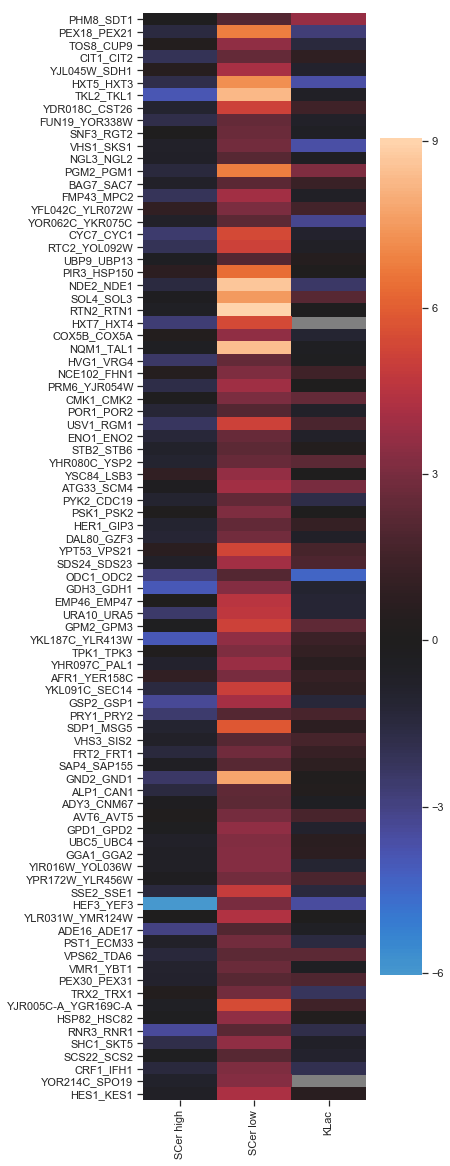

In [125]:
## Using same order and column names, visualize my rlog data

ohnologs_goi_kl_data['SC_common_name_high_low'] = ohnologs_goi_kl_data['SC_common_name_high'] + '_' + ohnologs_goi_kl_data['SC_common_name_low']

ohnologs_goi_kl_data.set_index('SC_common_name_high_low', inplace=True)

lfc_sorted = ohnologs_goi_kl_data.loc[expression_data_df_sorted.index, ['log2FoldChange_low','log2FoldChange_high', 'log2FoldChange_KL']]

fig_lfc, ax_lfc = plt.subplots(figsize=(5,20))

sns.heatmap(lfc_sorted, center = 0.0, ax=ax_lfc)

ax_lfc.set_facecolor("grey")
ax_lfc.set_xticklabels(['SCer high', 'SCer low', 'KLac'])

fig_lfc.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/LFC_goi.svg'))

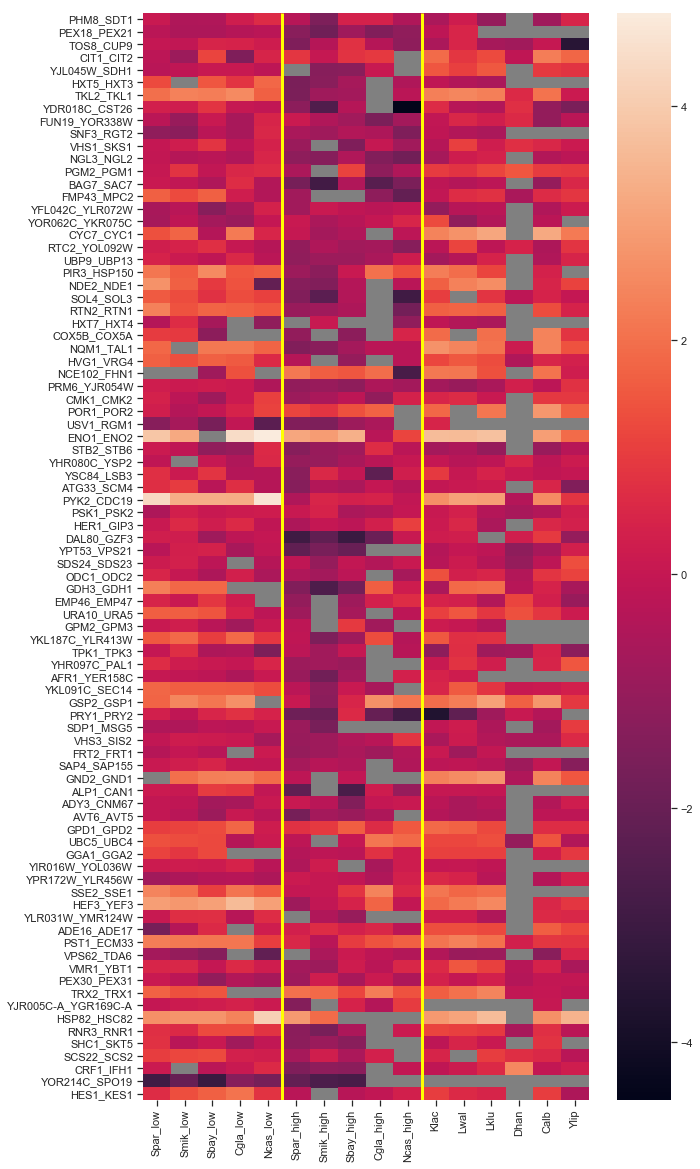

In [131]:
#heatmap prior to clustering, but after filtering wierd species and rows with many NANs

fig_hmap_tsankov, ax_hmap_tsankov = plt.subplots(figsize=(10,20))

# #Filter out S.Cer because its distribution is so different
# #Filter out D.Han because there are so many NANs (probably an indexing problem in the ortholog/expression array set)
raw_expression_data_df_spec_filter = raw_expression_data_df.drop(columns = ['Scer_low', 'Scer_high'])  #, 'Dhan'])

# #filter out a row if it has Ndrop or more missing orthologs
# inds_to_drop = []
# Ndrop = 5
# for ind, row in enumerate(raw_expression_data_df_spec_filter.values):
#      if sum(np.isnan(row)) >= Ndrop:
#         inds_to_drop.append(ind)
        
# rows_to_drop = raw_expression_data_df_spec_filter.index[inds_to_drop]
# print('Dropped the following Paralog Pairs because there were more than ' + str(Ndrop) + ' orthologs missing.')
# print(rows_to_drop)
# raw_expression_data_df_row_filter = raw_expression_data_df_spec_filter.drop(index=rows_to_drop)

raw_expression_data_df_sorted = raw_expression_data_df_spec_filter.loc[expression_data_df_sorted.index,:]

sns.heatmap(raw_expression_data_df_sorted, ax=ax_hmap_tsankov)

ax_hmap_tsankov.set_facecolor('grey')

big_lines_tsankov = []
tick_tracker = 0
for column in raw_expression_data_df_sorted.columns:
    tick_tracker = tick_tracker + 1
    if column in {'Ncas_low', 'Ncas_high'}:
        big_lines_tsankov.append(tick_tracker)
ax_hmap_tsankov.vlines(big_lines_tsankov, ymin = 0, ymax = len(raw_expression_data_df_sorted), color = 'yellow', linewidth = 3)

fig_hmap_tsankov.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/raw_exp_goi.svg'))

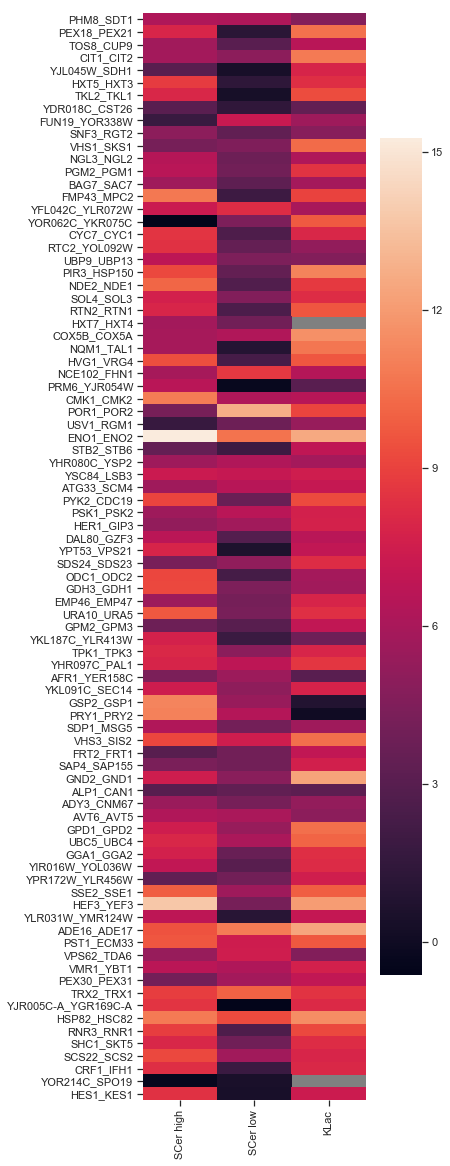

In [138]:
ohnologs_goi_rlog['SC_common_name_high_low'] = ohnologs_goi_rlog['SC_common_name_high'] + '_' + ohnologs_goi_rlog['SC_common_name_low']

ohnologs_goi_rlog.set_index('SC_common_name_high_low', inplace=True)

rlog_sorted = ohnologs_goi_rlog.loc[expression_data_df_sorted.index,['AS_WT_cont_mean_low', 'AS_WT_cont_mean_high', 'AS_WT_cont_mean_kl']]

fig_rlog, ax_rlog = plt.subplots(figsize=(5,20))

sns.heatmap(rlog_sorted,ax=ax_rlog)

ax_rlog.set_facecolor("grey")
ax_rlog.set_xticklabels(['SCer high', 'SCer low', 'KLac'])

fig_rlog.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/rlog_goi.svg'))

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

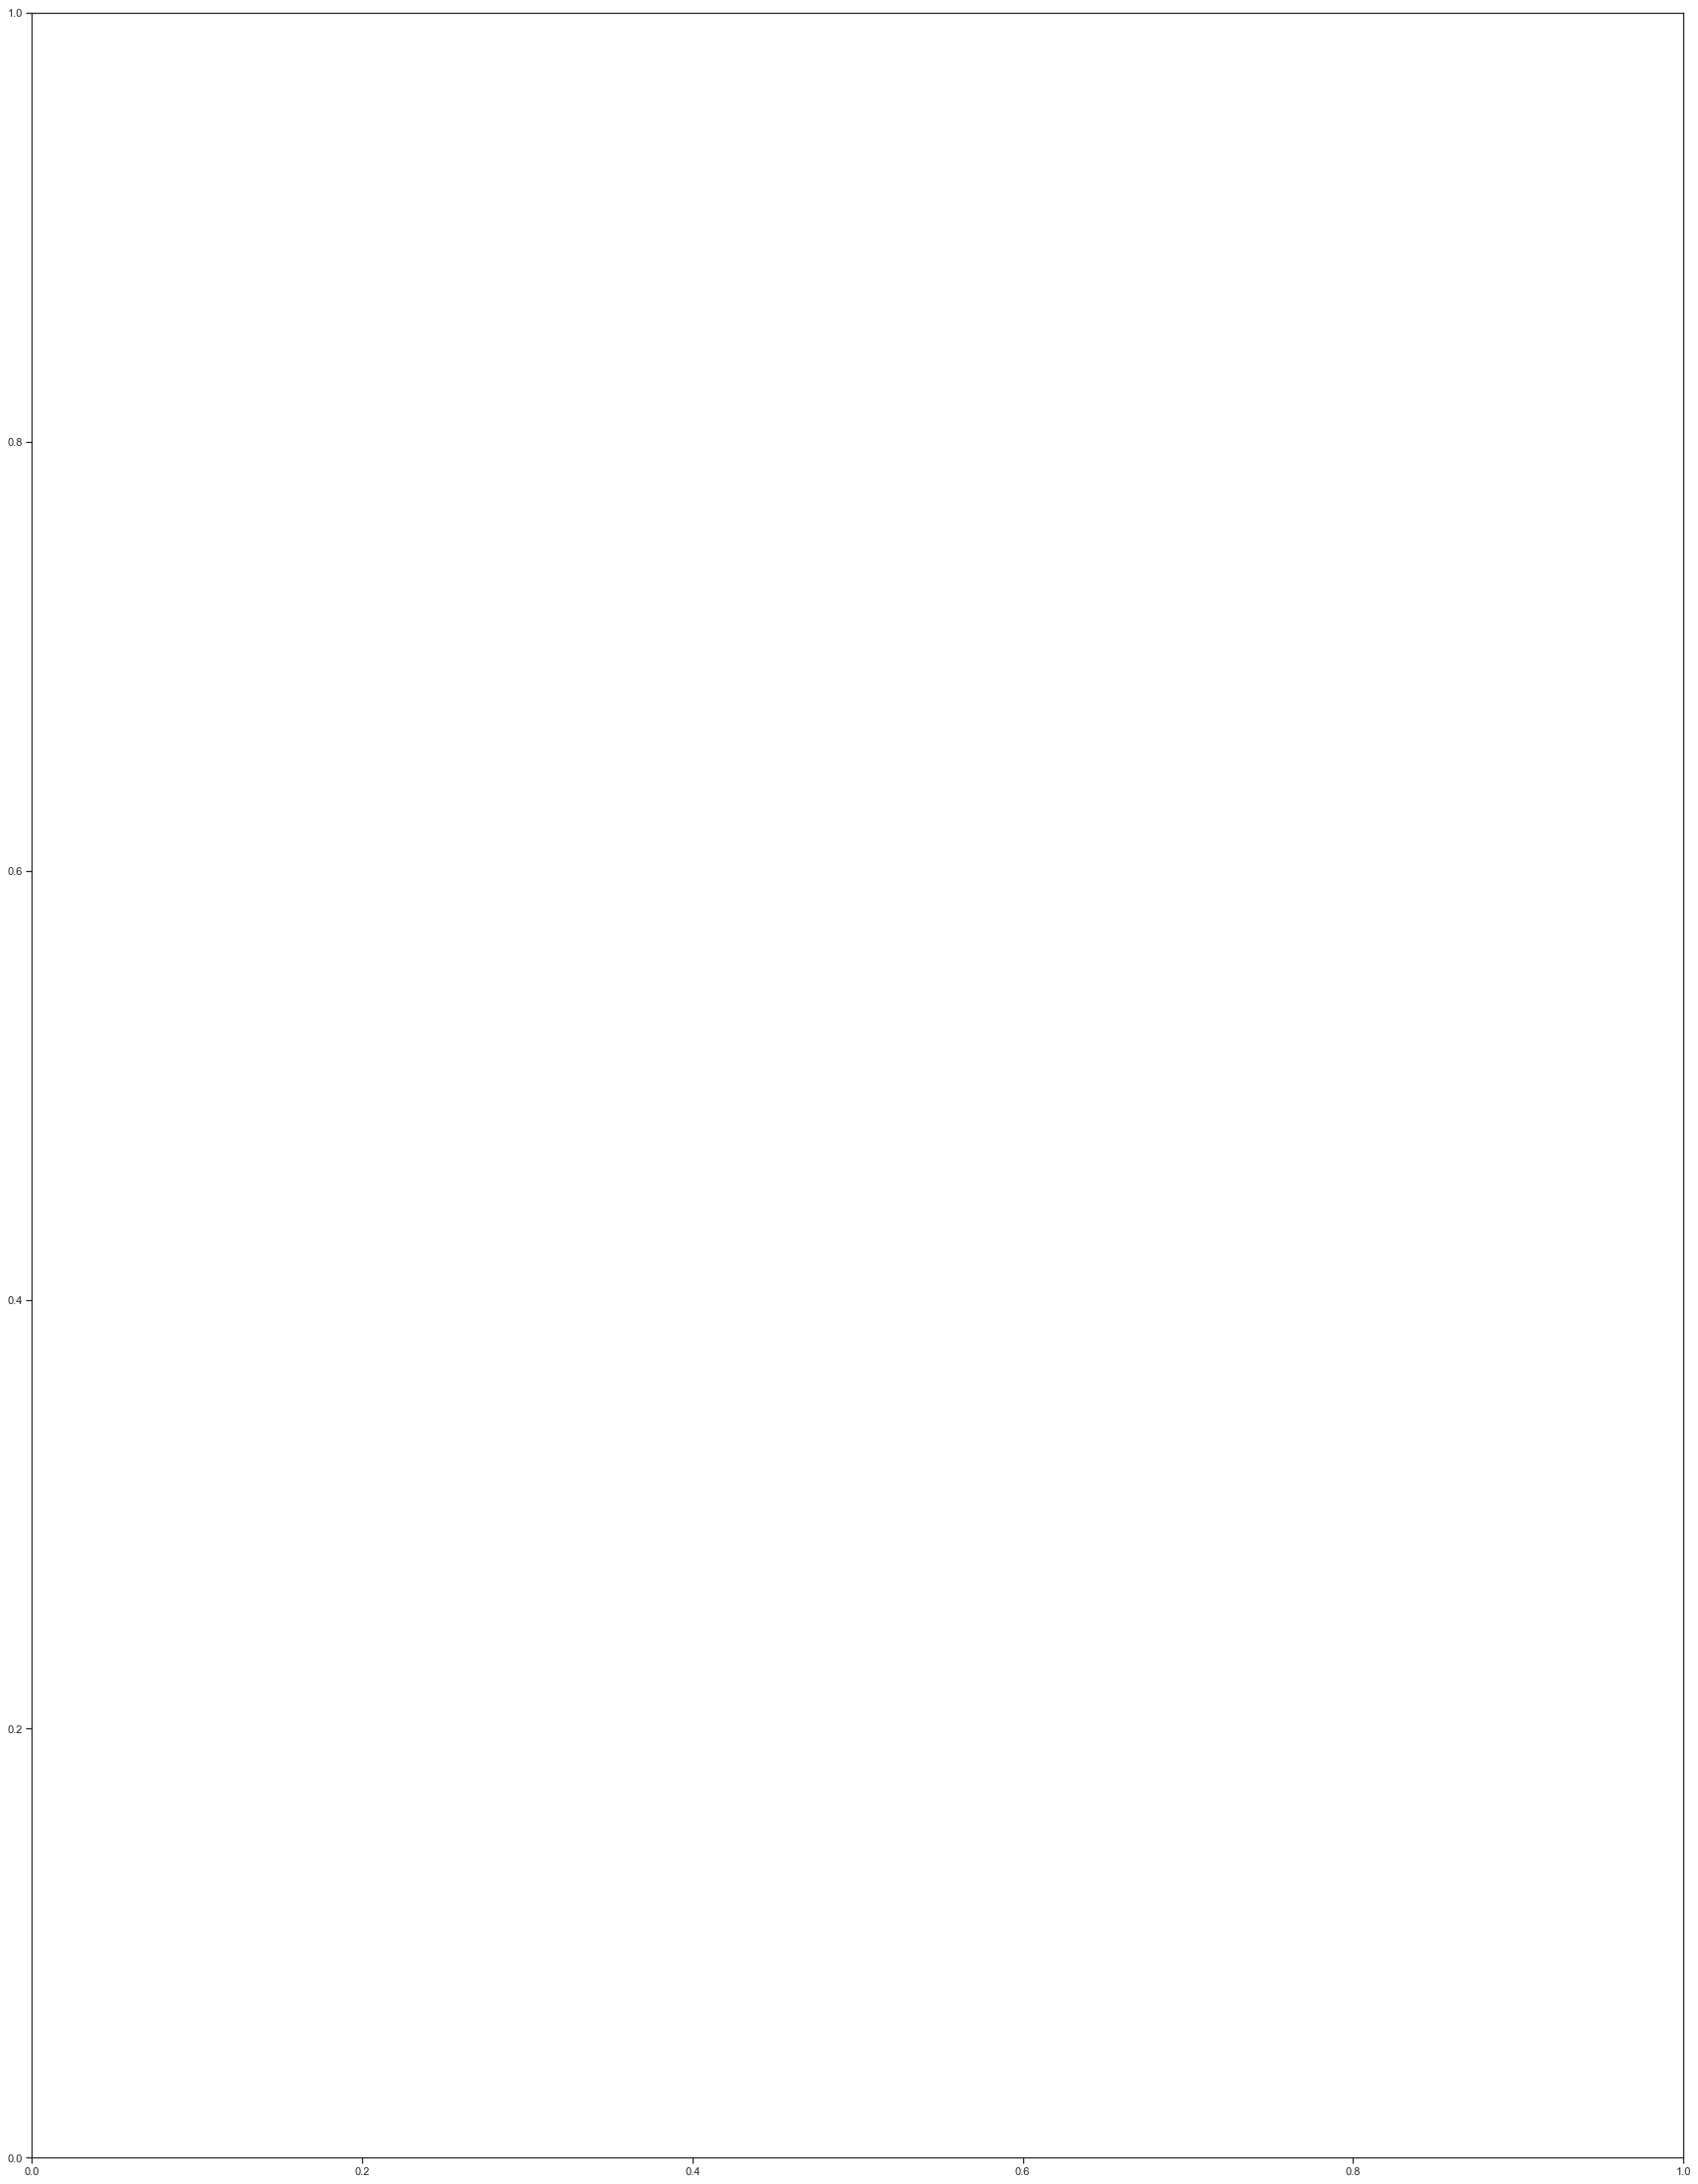

In [30]:
#Performs heirarchical clustering on filtered data.  Redraws histogram with clusters organized: 

columns_subset = []
spec_set_name = 'Post WGH high'
spec_set = spec_sets[spec_set_name]

level = levels[spec_set_name]
if level == '': 
    level_sep = ''
else: 
    level_sep = '_'
for spec in spec_set: 
    spec_columns = [spec + '_' + condition + level_sep + level for condition in list(spec_conditions[spec])]
    columns_subset = columns_subset + spec_columns

expression_data_df_subset = expression_data_df_row_filter.loc[:,columns_subset]

dm = spd.pdist(expression_data_df_subset.values, metric = io_library.correlation_nan_filt)
row_cluster = sch.linkage(dm, method='average', optimal_ordering=True)    #might also try 'centroid', 'median', and 'ward'

row_ind_reorder = sch.leaves_list(row_cluster)

old_rows = expression_data_df_row_filter.index.tolist()
new_rows = [old_rows[ind] for ind in row_ind_reorder]

expression_data_df_reorder = expression_data_df_row_filter.reindex(new_rows)


fig_hmfilt, ax_hmfilt = plt.subplots(figsize = (30,40))
sns.heatmap(expression_data_df_reorder, ax=ax_hmfilt)

fig_dend, ax_dend = plt.subplots()
sch.dendrogram(row_cluster, ax=ax_dend)




C:\Users\BMH_work\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



[Text(0.5,0,'Scer_DS/LOG_low'),
 Text(7.5,0,'Scer_NaCl_030_low'),
 Text(14.5,0,'Scer_hydrogen peroxide_005_low'),
 Text(21.5,0,'Spar_PLAT/LOG_low'),
 Text(28.5,0,'Sbay_DS/LOG_low'),
 Text(35.5,0,'Sbay_sbayuv_DS/LOG_low'),
 Text(42.5,0,'Cgla_DS/LOG_low'),
 Text(49.5,0,'Cgla_NaCl_015_low'),
 Text(56.5,0,'Cgla_heat shock_060_low'),
 Text(63.5,0,'Ncas_LAG/LOG_low'),
 Text(70.5,0,'Ncas_NaCl_060_low'),
 Text(77.5,0,'Ncas_hydrogen peroxide_015_low'),
 Text(84.5,0,'Vpol_PLAT/LOG_low'),
 Text(91.5,0,'Scer_NaCl_005_high'),
 Text(98.5,0,'Scer_heat shock_045_high'),
 Text(105.5,0,'Spar_LAG/LOG_high'),
 Text(112.5,0,'Smik_PLAT/LOG_high'),
 Text(119.5,0,'Sbay_PLAT/LOG_high'),
 Text(126.5,0,'Sbay_sbayuv_PLAT/LOG_high'),
 Text(133.5,0,'Cgla_PS/LOG_high'),
 Text(140.5,0,'Cgla_heat shock_030_high'),
 Text(147.5,0,'Ncas_DS/LOG_high'),
 Text(154.5,0,'Ncas_NaCl_015_high'),
 Text(161.5,0,'Ncas_heat shock_060_high'),
 Text(168.5,0,'Vpol_LL/LOG_high'),
 Text(175.5,0,'Klac_PLAT/LOG'),
 Text(182.5,0,'Klac_heat 

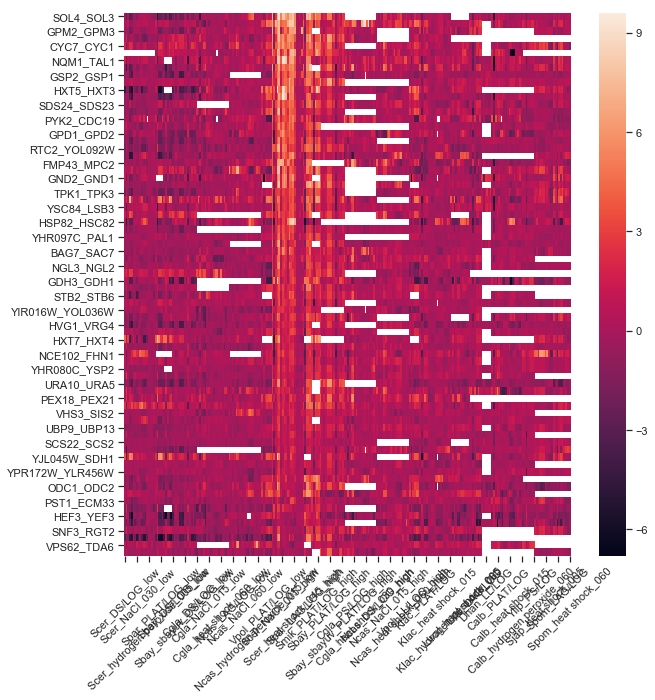

In [109]:
flat_clust = sch.fcluster(row_cluster,0.8, criterion='distance')

fig_clust2, ax_clust2 = plt.subplots(figsize=(10,10))

#pick data from a given cluster
cluster_no = 3
expression_data_clust = expression_data_df_row_filter[flat_clust==cluster_no]

#sort by average of the Scer_columns in the high level

#sort_columns

level = 'high'
level_sep = '_'
spec = 'Scer'
cols_to_avg = [spec + '_' + condition + level_sep + level for condition in list(spec_conditions[spec])]

expression_data_clust_subset =  expression_data_clust.loc[:,cols_to_avg]
expression_data_clust['high_scer_median'] = expression_data_clust_subset.median(axis=1)
expression_data_clust_sorted = expression_data_clust.sort_values(by='high_scer_median', ascending=False)
hm = sns.heatmap(expression_data_clust_sorted.drop(columns = 'high_scer_median') , ax=ax_clust2)
hm.set_xticklabels(hm.get_xticklabels(), rotation = 45)

In [ ]:
## Stack heatmap of Raw exp on top 

In [ ]:
PS/LOG
PLAT/LOG
DS/LOG
heat shock_30
heat shock_45

In [ ]:

#Smik missing mapping from ygob names to Regev lab orthogroups.  C.Gla mapping for Sec14 seems better with orthogroups than YGOB
#Going to start with orthogroup mapping from Regev lab for all of them. 
#K.Lac had a major discrepancy with annotation in regev lab data.   

#Species that have a column on the pillars file: 'Klac, Lwal, Lklu, Scer, Smik, Cgla, Ncas'
#Should also do one with Pillars orthologs

# Plot for a single gene (example was MPC2/MPC3) 

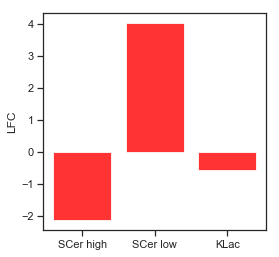

In [49]:
fig, ax = plt.subplots(figsize=(4,4))

sc_kl_mpc23_data = ohnologs_goi_kl_data[ohnologs_goi_kl_data['SC_common_name_low']=='MPC2'].loc[:,['log2FoldChange_low','log2FoldChange_high','log2FoldChange_KL']]

bar_width = 0.8
opacity = 0.8

ax.bar([0,1,2],sc_kl_mpc23_data.values[0], bar_width,
                             alpha=opacity,
                             color='red',
                             label='test') 
#                              #bottom = bottom)

#     if kk==2: 
#         ax.set_xlabel('Species')
ax.set_ylabel('LFC')
#     ax.set_ylim(-4,8)
#     ax.set_title(spec_set_name)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['SCer high', 'SCer low', 'KLac'])

fig.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/MPC23_LFC.svg'))


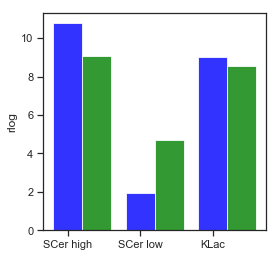

In [48]:
fig, ax = plt.subplots(figsize=(4,4))

bar_width = 0.4
opacity = 0.8
condition_mult = {'cont':0, 'drug': 1}
colors = {'cont': 'blue', 'drug': 'green'}
#Rlog values
sc_kl_mpc23_exp_data = {}
for condition in ['cont', 'drug']: 
    columns_to_view = ['AS_WT_' + condition + '_mean_' + spec_set  for spec_set in ['low', 'high', 'kl']]
    sc_kl_mpc23_exp_data[condition] = ohnologs_goi_rlog[ohnologs_goi_rlog['SC_common_name_low']=='MPC2'].loc[:,columns_to_view]
    
    ax.bar(np.array([0,1,2])+condition_mult[condition]*bar_width,
           sc_kl_mpc23_exp_data[condition].values[0], bar_width,
                 alpha=opacity,
                 color=colors[condition],
                 label=condition) 
    #                              #bottom = bottom)

#     if kk==2: 
#         ax.set_xlabel('Species')
ax.set_ylabel('rlog')
#     ax.set_ylim(-4,8)
#     ax.set_title(spec_set_name)
ax.set_xticks([0,1,2])
ax.set_xticklabels(['SCer high', 'SCer low', 'KLac'])
    
fig.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/MPC23_rlog.svg'))


# Look for DE sets using regev data in all species. 

In [2]:
#Load GOI ohnolog data

fname = data_processing_dir + os.sep + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_20181205.pkl')

with open(fname, 'rb') as file:
    [ohnologs_goi_pka,ohnologs_expression_sorted_pka,goi_criteria_pka] = pickle.load(file)
ohnologs_goi_pka.set_index('Ancestor', inplace=True)
ohnologs_expression_sorted_pka.set_index('Ancestor', inplace=True)

83


,genename_low,DS/LOG_low,LAG/LOG_low,LL/LOG_low,PLAT/LOG_low,PS/LOG_low,NaCl_005_low,NaCl_015_low,NaCl_030_low,NaCl_060_low,...,heat shock_005_high,heat shock_015_high,heat shock_030_high,heat shock_045_high,heat shock_060_high,hydrogen peroxide_005_high,hydrogen peroxide_015_high,hydrogen peroxide_030_high,hydrogen peroxide_060_high,PKAest_high
anc,,,,,,,,,,,,,,,,,,,,,
Anc_7.436,YBL101C,1.398995,-0.555903,0.603228,1.277380,1.397797,-0.149946,1.051866,1.009580,0.582741,...,1.424064,4.317677,1.647291,2.719863,0.553612,-0.042838,-0.052878,0.038047,0.601231,3.369863
Anc_5.644,YOR047C,-0.751063,0.980541,-0.190445,-2.031706,-2.215000,0.233388,-0.569751,-0.595237,-0.561071,...,1.945980,1.284570,0.275081,0.612031,0.017269,0.130937,0.032241,0.046878,0.200753,1.992352
Anc_5.318,YDR300C,-1.132156,0.419166,-0.655837,-1.874126,-2.834820,-0.060797,-0.731902,-1.552099,-1.198739,...,1.968126,3.125319,1.630938,2.927464,0.267521,0.061711,-0.020502,-0.020502,0.262879,3.819096
Anc_7.420,YBL089W,0.035900,0.269971,-0.077866,0.182497,0.665728,-0.478526,-0.226829,0.032016,-0.023551,...,0.740358,1.764671,2.391484,2.546383,1.961948,0.219256,0.339404,0.207683,0.460941,2.147370
Anc_5.370,YDR326C,-0.333764,0.245690,-0.207697,-0.588380,-0.462092,-0.460698,-0.566267,-0.481832,-0.470564,...,0.562892,1.828598,1.260515,1.345513,0.343757,-0.368562,-0.459049,-0.572647,-0.558157,1.980522
Anc_5.394,YHR092C,2.982318,-0.409223,2.284524,-2.756355,-0.358812,1.039610,0.122741,-1.722335,0.451757,...,1.278525,1.640270,0.967802,1.170270,0.487151,-0.048655,-0.223656,-0.439257,-0.603607,4.004944
Anc_5.395,YHR094C,-2.972693,3.125913,-2.940160,-3.854962,-3.731833,4.372832,3.963779,2.425652,2.867818,...,1.375058,1.710242,0.741915,0.787365,0.280636,-0.114440,-0.267534,-0.360669,-0.601404,4.215785
Anc_5.399,YDR348C,-0.141805,0.308081,-0.081329,0.053783,-0.077242,-0.200715,-0.131304,-0.013168,0.004902,...,1.551920,3.465362,1.634556,2.188555,0.172152,-0.102575,0.018181,1.283132,0.326054,2.772473
Anc_5.416,YHR108W,-0.218736,-1.772663,0.063698,-0.875102,-0.828668,0.000894,-0.239574,-0.374194,-0.084157,...,1.724120,2.755551,2.295931,2.628172,1.080751,0.055630,0.083460,0.173540,0.205274,2.462380


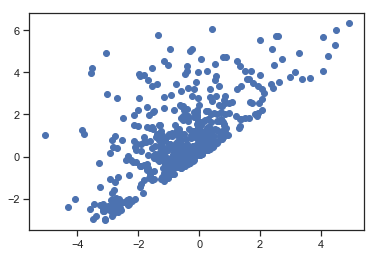

In [100]:
spec = 'Scer'
#Get all WGH paralogs pairs for a given species.  

ohnologs = io_library.get_WGH_pairs_by_spec(spec)



#load data
fname_array_data = os.path.normpath(data_processing_dir + 'regev_data/' + spec + '_growth_stress_norm.csv')  
spec_data = pd.read_csv(fname_array_data, index_col=0)
conditions = spec_data.columns

#Combine columns to get PKAest = pka activation estimate 
columns_to_combine = {'PS/LOG', 'PLAT/LOG', 'DS/LOG', 'heat shock_30', 'heat shock_45'}
     
#threshold for induction using the average of the combined columns that make up the PKA inhibition estimate.  
#All data is normalized already
    
#Make a column which is average fold change for these columns
columns_to_combine_spec = [column for column in conditions if column in columns_to_combine]
spec_data['PKAest'] = spec_data.loc[:,columns_to_combine_spec].apply(np.mean, axis = 1)


#Merge in expression data for all those paralogs, sort on average/individual conditions
sort_column = 'PKAest'
sort_column_fname = ''.join('cat'.split('/'))

ohnologs_sorted = io_library.join_ohnologs_and_sort(spec_data, ohnologs, sort_column)

plt.scatter(ohnologs_sorted[sort_column + '_low'], ohnologs_sorted[sort_column + '_high'])

#Pick differentially expressed paralogs (using average / individual conditions)
min_high_lfc = 1.8  # Minimum LFC for the high activation paralog
lfc_diff = 1.8 # Difference in LFC to call a differentially expressed paralog
max_low_lfc = 1.6 # Maximum LFC that low activation paralog can have.  I get a ~20 more if I use 2.5 as the cutoff

goi_criteria = {'min_high_lfc': min_high_lfc, 'lfc_diff': lfc_diff, 'max_low_lfc' : max_low_lfc}

ohnologs_goi = ohnologs_sorted[(ohnologs_sorted[sort_column + '_high']>min_high_lfc) &
                                          ((ohnologs_sorted[sort_column + '_high']-ohnologs_sorted[sort_column +'_low'])>lfc_diff) &
                                          (ohnologs_sorted[sort_column + '_low'] < max_low_lfc)]

print(len(ohnologs_goi))

#Save list and all sorted ohnolog dataframe as well
fname = data_processing_dir + os.path.normpath('kl_sc_PKA_as_m24_r1g1_20181017/gois_' + spec + '_' + sort_column_fname + '_20190123.pkl')

with open(fname, 'wb') as file:
    pickle.dump([ohnologs_goi,ohnologs_sorted,goi_criteria], file)
                                          
ohnologs_goi
        

#Get all orthologs from other species arranged appropriately for that species. 

#Merge in expression data for all the genes

#Sort by conservation

#Heatmap

Differentially expressed ohnologs were chosen according to four criteria: 
    1) The minimum fold change for the activated paralog was greater than high_min = 2.0. 
    2) The maximum fold change of the low paralog was less than low_max= 1.5. 
    3) There was a difference of at least diff_min= 2.0 in LFC between the high and low paralog

There are 7 genes in my RNA seq data that are not in the regev data. There are 33 genes in the regev data that are not in my RNA seq data


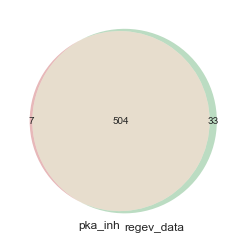

In [101]:
#venn2([set(ohnologs_goi_pka.index),set(ohnologs_goi.index)])
venn2([set(ohnologs_expression_sorted_pka.index),set(ohnologs_sorted.index)], set_labels=['pka_inh', 'regev_data'])
pka_not_regev = set(ohnologs_expression_sorted_pka.index)-set(ohnologs_sorted.index)
regev_not_pka = set(ohnologs_sorted.index) - set(ohnologs_expression_sorted_pka.index)
print('There are ' + str(len(pka_not_regev)) + ' genes in my RNA seq data that are not in the regev data. There are ' + 
      str(len(regev_not_pka)) + ' genes in the regev data that are not in my RNA seq data')

Trimmed 5 ohnolog pairs from pka goi
Trimmed 3 ohnolog pairs from regev goi


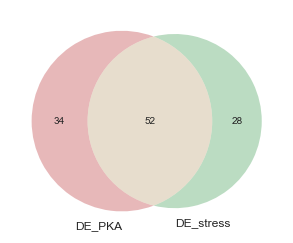

In [118]:
ohnologs_goi_pka_trimmed = ohnologs_goi_pka.loc[(set(ohnologs_goi_pka.index) - pka_not_regev),:]
print('Trimmed ' + str(len(ohnologs_goi_pka)-len(ohnologs_goi_pka_trimmed)) + ' ohnolog pairs from pka goi')

ohnologs_goi_trimmed = ohnologs_goi.loc[(set(ohnologs_goi.index) - regev_not_pka),:]
print('Trimmed ' + str(len(ohnologs_goi)-len(ohnologs_goi_trimmed)) + ' ohnolog pairs from regev goi')

venn2([set(ohnologs_goi_pka_trimmed.index),set(ohnologs_goi_trimmed.index)], set_labels=['DE_PKA', 'DE_stress'])

In [103]:
#superimpose goi from regev data onto lfc data in S.Cer

#Separate into different groups: 

plot_subsets = {'all': ohnologs_expression_sorted_pka, 
                'DEpka': ohnologs_expression_sorted_pka.loc[ohnologs_goi_pka_trimmed.index,:],
                'DE' + sort_column_fname: ohnologs_expression_sorted_pka.loc[ohnologs_goi_trimmed.index,:]}


params =  {'all': {'color':'grey', 'alpha': 0.3},
           'DEpka': {'color':'red', 'alpha':0.4},
           'DE' + sort_column_fname: {'color':'blue', 'alpha':0.4}
          }
            


data = []


                                 
for subset_name, subset in plot_subsets.items():
                                 
    trace = pygo.Scatter(
                x = subset['log2FoldChange_low'], #-np.log10(deseq_data['padj_pkainh']), #
                y = subset['log2FoldChange_high'] ,
                text = subset['SC_common_name_high'] + ' ' + subset.index,
                mode = 'markers',
                marker = {'opacity': params[subset_name]['alpha'],
                          'color' : params[subset_name]['color'],
                          #'colorscale' : 'Jet',
                          #'showscale' : False}  #
                         },
                name = subset_name
                
                )
        
    data.append(trace)


layout = pygo.Layout(
    xaxis= {
        #"range":[-2, 20],
        "title":'LFC_low'
    },
    yaxis= {
        #"range":[-2, 20],
        "title":'LFC_high'
    }
)


fig = pygo.Figure(data=data, layout = layout)
py.iplot(fig, filename='PKA_vs_condition_DE_genes_SC')

In [138]:
anc = 'Anc_8.477'
ohnologs_sorted.loc[anc,:]
#ohnologs_expression_sorted_pka.loc[anc,:]

genename_low                    YPL026C
DS/LOG_low                    0.0590611
LAG/LOG_low                     2.00998
LL/LOG_low                     0.233548
PLAT/LOG_low                   0.880744
PS/LOG_low                    -0.337765
NaCl_005_low                   -0.19614
NaCl_015_low                  -0.930108
NaCl_030_low                  -0.453836
NaCl_060_low                   0.376005
heat shock_005_low              0.56236
heat shock_015_low             -0.13492
heat shock_030_low            -0.511262
heat shock_045_low            -0.240309
heat shock_060_low            -0.416822
hydrogen peroxide_005_low     -0.117794
hydrogen peroxide_015_low    -0.0509553
hydrogen peroxide_030_low     -0.386088
hydrogen peroxide_060_low     -0.373027
PKAest_low                      0.20068
genename_high                   YDR247W
DS/LOG_high                     1.76911
LAG/LOG_high                  -0.389812
LL/LOG_high                     1.21566
PLAT/LOG_high                   1.37433


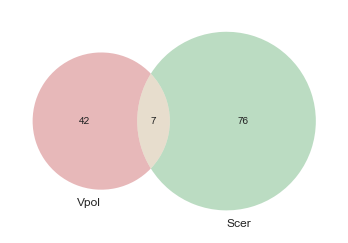

In [106]:
#Overlap of Vpol and SCer
venn2([set(ohnologs_goi_vpol.index),set(ohnologs_goi_scer.index)], set_labels=['Vpol', 'Scer'])

In [117]:
#what are the seven that overlap
ohnologs_goi_scer_vpol = ohnologs_goi_scer.loc[set(ohnologs_goi_vpol.index)&set(ohnologs_goi_scer.index), ['genename_low', 'genename_high']]
for level in ['low','high']: 
    ohnologs_goi_scer_vpol['SC_common_name_' + level] = io_library.SC_common_name_lookup(ohnologs_goi_scer_vpol['genename_'+level])

ohnologs_goi_scer_vpol.loc[:,['SC_common_name_low','SC_common_name_high']]

,SC_common_name_low,SC_common_name_high
anc,,
Anc_3.372,TKL1,TKL2
Anc_5.396,HXT3,HXT5
Anc_2.445,PGM1,PGM2
Anc_2.418,ADE16,ADE17
Anc_2.113,YHR131C,YNL144C
Anc_7.69,FRT1,FRT2
Anc_3.244,CST26,YDR018C


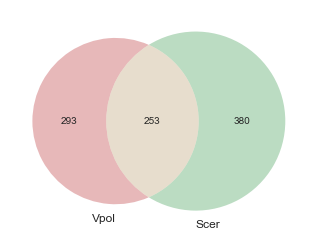

In [109]:
#overlap of all WGH paralogs between species

ohnologs_vpol = io_library.get_WGH_pairs_by_spec('Vpol')
ohnologs_scer = io_library.get_WGH_pairs_by_spec('Scer')
venn2([set(ohnologs_vpol.index),set(ohnologs_scer.index)], set_labels=['Vpol', 'Scer'])

In [ ]:
#From S.Cer perspective, look at Gene expression conservation

#Might have data errors for YKL104C/YMR085W/YMR084W that is handled differently 
#between YGOB and regev lab paralogs. 

In [49]:
self_spec = 'Scer'
sort_column = 'PKAest'

#Order that we view the species (minus S.Cer)
spec_order_post_WGH = ['Spar','Smik', 'Sbay','Suva','Cgla', 'Ncas','Vpol']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

ohnologs_goi_array, spec_conditions = io_library.load_regev_data_gois(ohnologs_goi, sort_column, self_spec, spec_order_post_WGH, spec_order_pre_WGH)

#add in SC_common_name columns
for level in ['low', 'high']:
    ohnologs_goi_array['SC_common_name_' + level] = io_library.SC_common_name_lookup(ohnologs_goi_array['Scer_genename_' + level])


I am importing io_library
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = othera
base directory is C:\Users\BMH_work\github\expression_broad_data
data processing dir is C:\Users\BMH_work\github\expression_broad_data\expression_data\
YHR183W has NONE listed in ortholog file for Spar
YDR342C has NONE listed in ortholog file for Spar
YDR343C has NONE listed in ortholog file for Spar
YPL200W has NONE listed in ortholog file for Spar
YMR085W has NONE listed in ortholog file for Spar
YOL131W has NONE listed in ortholog file for Spar
YDR326C has NONE listed in ortholog file for Smik
YHR094C has NONE listed in ortholog file for Smik
YOL024W has NONE listed in ortholog file for Smik
YLR354C has NONE listed in ortholog file for Smik
YDR345C has NONE listed in ortholog file for Smik
YNL309W has NONE listed in ortholog file for Smik
YOR153W has NONE listed in ortholog file for Smik
YNR047W has NONE listed in ortholog file for Smik
YDR343C has NONE listed in ortho

YOR047C has NONE listed in ortholog file for Vpol
YHR092C has NONE listed in ortholog file for Vpol
YHR094C has NONE listed in ortholog file for Vpol
YHR108W has NONE listed in ortholog file for Vpol
YJR048W has NONE listed in ortholog file for Vpol
YOL024W has NONE listed in ortholog file for Vpol
YGL253W has NONE listed in ortholog file for Vpol
YPL177C has NONE listed in ortholog file for Vpol
Mismatch between ortholog file and expression data index Vpol : Kpol_YGOB_1033.45 DS/LOG
Mismatch between ortholog file and expression data index Vpol : Kpol_YGOB_1033.45 LAG/LOG
Mismatch between ortholog file and expression data index Vpol : Kpol_YGOB_1033.45 LL/LOG
Mismatch between ortholog file and expression data index Vpol : Kpol_YGOB_1033.45 LPS/LOG
Mismatch between ortholog file and expression data index Vpol : Kpol_YGOB_1033.45 PLAT/LOG
Mismatch between ortholog file and expression data index Vpol : Kpol_YGOB_1033.45 PS/LOG
YLR371W has NONE listed in ortholog file for Vpol
YHR162W has 

Mismatch between ortholog file and expression data index Dhan : DEHA0D17116g LL/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0D17116g LPS/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0D17116g PLAT/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0D17116g PS/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0G15730g ELL/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0G15730g LAG/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0G15730g LL/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0G15730g LPS/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0G15730g PLAT/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0G15730g PS/LOG
Mismatch between ortholog file and expression data index Dhan : DEHA0B16016g ELL/LOG
Mismatch between ortholog file and expression data index Dhan : DEH

YBL101C has NONE listed in ortholog file for Ylip
YHR092C has NONE listed in ortholog file for Ylip
YHR094C has NONE listed in ortholog file for Ylip
YOL024W has NONE listed in ortholog file for Ylip
YGL075C has NONE listed in ortholog file for Ylip
YDR345C has NONE listed in ortholog file for Ylip
YKR013W has NONE listed in ortholog file for Ylip
YLR413W has NONE listed in ortholog file for Ylip
YOL086C has NONE listed in ortholog file for Ylip
YPL106C has NONE listed in ortholog file for Ylip
YML125C has NONE listed in ortholog file for Ylip
YMR182C has NONE listed in ortholog file for Ylip
YOR324C has NONE listed in ortholog file for Ylip
YNL309W has NONE listed in ortholog file for Ylip
YGL104C has NONE listed in ortholog file for Ylip
YOL036W has NONE listed in ortholog file for Ylip
YOR153W has NONE listed in ortholog file for Ylip
YDL138W has NONE listed in ortholog file for Ylip
YOL056W has NONE listed in ortholog file for Ylip
YLR099C has NONE listed in ortholog file for Ylip


In [50]:
#Go through each of my GOIs and replace lists with single value for each item. 
#This is mainly to combine any values for genes that had a small scale duplication. 

# spec_order_post_WGH = ['Spar','Sbay','Smik','Suva', 'Cgla', 'Ncas','Vpol']
# spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

expression_data_df = io_library.regev_ohnolog_expression_data_SSD_combine(ohnologs_goi_array,  spec_sets, spec_conditions, combine_method = 'mean')


In [51]:
# Organize species conditions by a given vector of all possible conditions
spec_order_post_WGH = ['Spar','Sbay','Smik','Suva', 'Cgla', 'Ncas','Vpol']
spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

spec_sets = {'Post WGH low' : ['Scer'] + spec_order_post_WGH, 
             'Post WGH high' : ['Scer'] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

#filter out a row if it has Ndrop or more missing values
inds_to_drop = []
Ndrop = 130
for ind, row in enumerate(expression_data_df.values):
    if sum(np.isnan(row)) >= Ndrop:
        inds_to_drop.append(ind)
        
rows_to_drop = expression_data_df.index[inds_to_drop]
print('Dropped the following Paralog Pairs because there were more than ' + str(Ndrop) + ' orthologs missing.')
print(rows_to_drop)
expression_data_df_row_filter = expression_data_df.drop(index=rows_to_drop)

#Sort dataset by how long high expression for a PKA estimate column (PKAest) is retained in the high paralog in post WGH high gene
#Sort out rows by whether the averaged "PKAest" or PKA estimate columns are above a threshold.  
#Sort by the species farthes from original species first (so top row will be most conserved)

columns_to_combine = {'PS/LOG', 'PLAT/LOG', 'DS/LOG', 'heat shock_30', 'heat shock_45'}
    
#threshold for induction using the average of the combined columns that make up the PKA inhibition estimate.  
#All data is normalized already
induced_thresh = 2.5

expression_data_df_sorted = io_library.sort_conservaton_by_col_avg(expression_data_df_row_filter, spec_sets['Post WGH high'], columns_to_combine, induced_thresh )

#Sort conditions by defined order
all_conds = ['LAG/LOG','LL/LOG','ELL/LOG','DS/LOG','EPS/LOG','PS/LOG','LPS/LOG','PLAT/LOG',
     'NaCl_005',
     'NaCl_015',
     'NaCl_030',
     'NaCl_060', 
     'heat shock_005',
     'heat shock_015',
     'heat shock_030',
     'heat shock_045',
     'heat shock_060',
     'hydrogen peroxide_005',
     'hydrogen peroxide_015',
     'hydrogen peroxide_030',
     'hydrogen peroxide_060']

new_col_order = io_library.sort_regev_stress_conditions(all_conds, spec_sets, expression_data_df)

#add back in the new column order and drop out the extra columns that were added
expression_data_df_sorted = expression_data_df_sorted.loc[:,new_col_order]
expression_data_df_sorted

Dropped the following Paralog Pairs because there were more than 130 orthologs missing.
Index([], dtype='object')


,Scer_LAG/LOG_low,Scer_LL/LOG_low,Scer_DS/LOG_low,Scer_PS/LOG_low,Scer_PLAT/LOG_low,Scer_NaCl_005_low,Scer_NaCl_015_low,Scer_NaCl_030_low,Scer_NaCl_060_low,Scer_heat shock_005_low,...,Spom_LAG/LOG,Spom_LL/LOG,Spom_ELL/LOG,Spom_DS/LOG,Spom_PS/LOG,Spom_PLAT/LOG,Spom_heat shock_005,Spom_heat shock_015,Spom_heat shock_030,Spom_heat shock_060
YNL144C_YHR131C,0.458158,0.049467,0.187634,0.538506,0.377100,-0.284810,0.233723,0.258372,0.058446,-0.243483,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
IGD1_YOL024W,-1.462105,-0.945186,-0.497240,0.009928,-0.277972,0.396002,0.998832,1.287743,0.446830,0.289520,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
YDR018C_CST26,-0.334484,-0.284856,-0.532945,-1.428550,-1.160796,-0.388764,-1.040176,-0.421319,-0.703913,-0.245356,...,-0.351894,-0.798956,-0.467964,-0.812772,-0.882568,-0.831009,-0.383907,-0.446413,-0.376620,-0.279779
HXK1_HXK2,-1.984032,-0.006637,0.313407,-4.376632,-5.092161,0.181712,0.164597,-1.006272,-0.885392,0.144312,...,-0.847939,0.781406,0.731428,1.055590,0.939465,0.913596,-0.270917,-0.400278,-0.504190,-0.471213
PGM2_PGM1,-3.108500,-0.232005,-0.652216,-1.533658,-2.452153,0.064685,-0.139666,-0.817405,-1.114666,0.094165,...,-1.222808,1.868022,0.823594,1.834939,1.813976,1.641174,0.225916,0.587346,0.715425,0.421450
FUN19_YOR338W,6.534410,-1.545855,-0.245819,1.020116,1.128672,0.042722,-0.268051,-0.125756,-0.751617,-0.266851,...,0.227639,-1.056614,-0.555745,-1.061222,-0.970228,-0.976973,-0.630311,-1.199820,-1.139128,-0.519054
MPC3_MPC2,0.337398,-0.289132,-0.374033,-0.496766,-0.328078,0.119562,-0.097276,-0.603373,-0.452102,-0.022043,...,-0.021504,0.004862,-0.325620,0.156758,0.223441,0.120665,-0.737023,-0.503724,-1.274745,-1.079535
REG2_REG1,-0.146031,0.215634,0.326803,0.473277,0.481354,-0.149521,0.222698,0.503950,0.328995,-0.162477,...,0.126598,1.127877,0.893159,1.176489,1.122943,1.312207,-0.263700,-0.456760,-0.558347,-0.431478
HXT6_HXT1,3.125913,-2.940160,-2.972693,-3.731833,-3.854962,4.372832,3.963779,2.425652,2.867818,-0.531220,...,-0.361889,1.553167,1.217325,1.593206,1.670377,1.408259,0.293390,-0.254039,-0.854855,-0.599415
CYC7_CYC1,-1.186582,0.604370,1.294435,1.545158,1.662653,-0.361054,-0.355985,0.499594,0.970035,-0.003500,...,-2.358371,2.059319,0.595206,2.322280,2.481901,2.640547,0.029934,0.126582,-0.213533,-0.870908


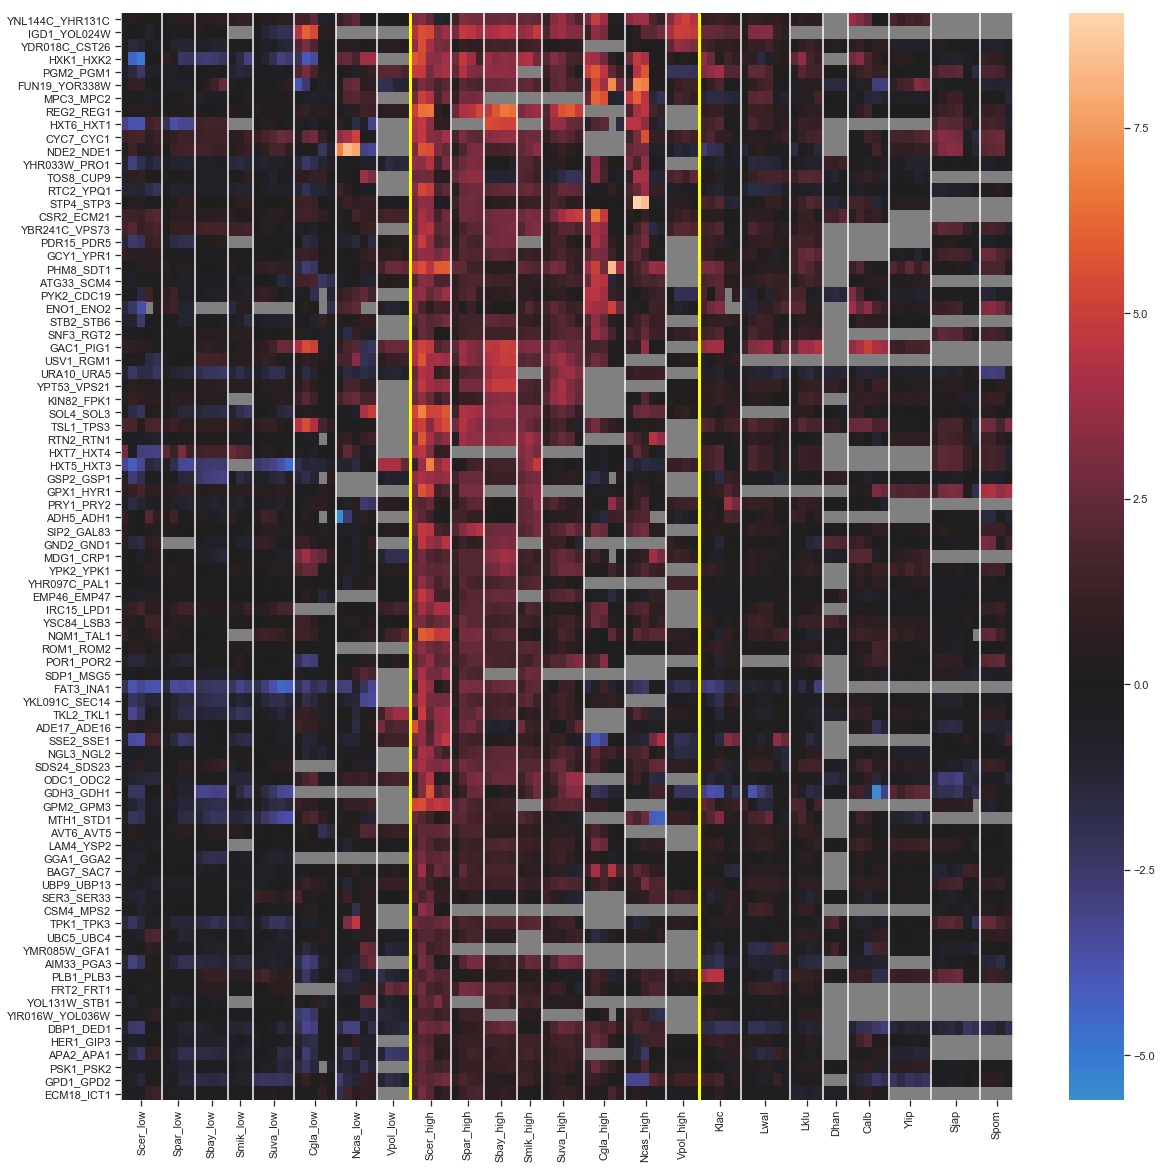

In [52]:
#heatmap after filtering and sorting

fig_hmap_exp, ax_hmap_exp = plt.subplots(figsize=(20,20))

#Make subset that only has columns with appropriate conditions:
conds_pka_corr = ['DS/LOG', 'PS/LOG', 'PLAT/LOG',
                    'heat shock_030', 'heat shock_045']

new_columns = []
for column in expression_data_df_sorted.columns: 
    pass_test = False
    for cond in conds_pka_corr:
        if cond in column: 
            pass_test=True

    if pass_test:
        new_columns.append(column)
        
expression_data_df_pka_corr = expression_data_df_sorted.loc[:,new_columns]    
   

#Make labels for each species, and separate out pre/post WGH and post WGH high/low with yellow lines
N_spec_level = {}

label_order = []
for level in ['low','high']:
    for spec in spec_sets['Post WGH ' + level]:
        label = spec + '_' + level
        N_spec_level[label] = 0
        label_order.append(label)
for spec in spec_sets['Pre WGH']: 
    label = spec
    N_spec_level[label] = 0 
    label_order.append(label)


for column in expression_data_df_pka_corr.columns: 
    spec = column.split('_')[0]
    if spec in set(spec_sets['Post WGH low']):
        level_sep = '_'
        level = column.split('_')[-1]
    else: 
        level_sep = ''
        level = ''
    label = spec + level_sep + level
    N_spec_level[label] = N_spec_level[label] + 1
    
new_ticks = []
sep_lines = [0]
new_tick_labels = []
big_lines = []
tick_tracker = 0
for label in label_order:
    N_tick_dist = N_spec_level[label]
    new_ticks.append(tick_tracker + N_tick_dist/2)
    new_tick_labels.append(label)
    sep_lines.append(tick_tracker + N_tick_dist)
    #new_tick_labels.append('')
    tick_tracker = tick_tracker + N_tick_dist
    if label in {'Vpol_low', 'Vpol_high'}:
        big_lines.append(tick_tracker)



sns.heatmap(expression_data_df_pka_corr, center = 0.0, xticklabels=False, ax = ax_hmap_exp)
ax_hmap_exp.set_facecolor('grey')
ax_hmap_exp.set_xticks(new_ticks)
ax_hmap_exp.set_xticklabels(new_tick_labels, rotation = 90)  #rotation=45, ha='right')
ax_hmap_exp.vlines(sep_lines, ymin = 0, ymax = len(expression_data_df_pka_corr), colors = 'white')
ax_hmap_exp.vlines(big_lines, ymin = 0, ymax = len(expression_data_df_pka_corr), colors = 'yellow',linewidth=3)
ax_hmap_exp.set_rasterized(True)    #Had to do this because .svg took ages on inkscape to work with
fig_hmap_exp.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/exp_goi_regev_SC_PKA_est_corr.svg'))

In [ ]:
#From Vpol perspective, look at gene expression conservation

In [67]:
#Only need to build once 
# self_spec = 'Vpol'
# spec_order_post_WGH = ['Ncas','Cgla','Suva','Sbay','Smik', 'Scer' ] 
# spec_order_pre_WGH = ['Klac','Lwal','Lklu'] 
# specs_to_build = spec_order_post_WGH+spec_order_pre_WGH
# for spec in specs_to_build: 
#     print(spec)
#     io_library.write_YGOB_orth_lookup_table(self_spec, spec)


I am importing io_library
what computer are you on? a = Ben's laptop, b = gpucluster, c = Ben's desktop, d = othera
base directory is C:\Users\BMH_work\github\expression_broad_data
data processing dir is C:\Users\BMH_work\github\expression_broad_data\expression_data\
Ncas
Cgla
Suva
Sbay
Smik
Scer
Klac
Lwal
Lklu


In [92]:
self_spec = 'Vpol'
sort_column = 'PKAest'

#eventually it would be good to add back in other species that weren't in pillars.  

#Order that we view the species (minus self_spec)
spec_order_post_WGH = ['Cgla', 'Scer' ]  #removed Spar because it wasn't in pillars, 
#Removed Ncas, Suva, Sbay, Smik, Lwal because the YGOB names don't match the Fungal orthogroups names (YGOB seem right)
spec_order_pre_WGH = ['Klac','Lklu']  #removed Dhan, Calb, Ylip Sjap, Spom because they weren't in pillars

ohnologs_goi_array, spec_conditions = io_library.load_regev_data_gois(ohnologs_goi, sort_column, self_spec, spec_order_post_WGH, spec_order_pre_WGH)

#add in SC_common_name columns
# for level in ['low', 'high']:
#     ohnologs_goi_array['SC_common_name_' + level] = io_library.SC_common_name_lookup(ohnologs_goi_array['Scer_genename_' + level])

orth_dir = data_processing_dir + 'ortholog_files' + os.sep 
vpol_scer_lookup = io_library.read_orth_lookup_table('Vpol', 'Scer', orth_dir)

for level in ['low', 'high']: 
    SC_common_names = []
    for vpol_gene in list(ohnologs_goi_array['Vpol_genename_' + level]): 
        scer_genes = vpol_scer_lookup[vpol_gene]
        if scer_genes == ['NONE']:
            scer_genes = [vpol_gene]
        scer_common_names = io_library.SC_common_name_lookup(scer_genes)
        SC_common_names.append('_'.join(scer_common_names))
    print('here')
    ohnologs_goi_array['SC_common_name_' + level] = SC_common_names


Kpol_1036.28 has NONE listed in ortholog file for Cgla
Kpol_1062.12 has NONE listed in ortholog file for Cgla
Kpol_1002.123 has NONE listed in ortholog file for Cgla
Kpol_1064.4 has NONE listed in ortholog file for Cgla
Kpol_1018.36 has NONE listed in ortholog file for Cgla
Kpol_208.4 has NONE listed in ortholog file for Cgla
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g DS/LOG
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g ELL/LOG
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g LAG/LOG
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g LL/LOG
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g PLAT/LOG
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g PS/LOG
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g NaCl_005
Mismatch between ortholog file and expression data index Cgla : CAGL0D05318g N

Mismatch between ortholog file and expression data index Klac : KLLA0E02355g DS/LOG
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g LAG/LOG
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g LL/LOG
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g PLAT/LOG
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g PS/LOG
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g NaCl_005
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g NaCl_015
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g NaCl_030
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g NaCl_060
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g heat shock_005
Mismatch between ortholog file and expression data index Klac : KLLA0E02355g heat shock_015
Mismatch between ortholog file and expression dat

here
here


In [93]:
#Go through each of my GOIs and replace lists with single value for each item. 
#This is mainly to combine any values for genes that had a small scale duplication. 

# spec_order_post_WGH = ['Spar','Sbay','Smik','Suva', 'Cgla', 'Ncas','Vpol']
# spec_order_pre_WGH = ['Klac','Lwal','Lklu','Dhan', 'Calb', 'Ylip','Sjap','Spom']

spec_sets = {'Post WGH low' : [self_spec] + spec_order_post_WGH, 
             'Post WGH high' : [self_spec] + spec_order_post_WGH, 
             'Pre WGH' : spec_order_pre_WGH} 

expression_data_df = io_library.regev_ohnolog_expression_data_SSD_combine(ohnologs_goi_array,  spec_sets, spec_conditions, combine_method = 'mean')


In [97]:
# Organize species conditions by a given vector of all possible conditions

#using same spec_sets as above

#filter out a row if it has Ndrop or more missing values
# inds_to_drop = []
# Ndrop = 130
# for ind, row in enumerate(expression_data_df.values):
#     if sum(np.isnan(row)) >= Ndrop:
#         inds_to_drop.append(ind)
        
# rows_to_drop = expression_data_df.index[inds_to_drop]
# print('Dropped the following Paralog Pairs because there were more than ' + str(Ndrop) + ' orthologs missing.')
# print(rows_to_drop)
# expression_data_df_row_filter = expression_data_df.drop(index=rows_to_drop)

expression_data_df_row_filter = expression_data_df

#Sort dataset by how long high expression for a PKA estimate column (PKAest) is retained in the high paralog in post WGH high gene
#Sort out rows by whether the averaged "PKAest" or PKA estimate columns are above a threshold.  
#Sort by the species farthes from original species first (so top row will be most conserved)

columns_to_combine = {'PS/LOG', 'PLAT/LOG', 'DS/LOG', 'heat shock_30', 'heat shock_45'}
    
#threshold for induction using the average of the combined columns that make up the PKA inhibition estimate.  
#All data is normalized already
induced_thresh = 2.5

expression_data_df_sorted = io_library.sort_conservaton_by_col_avg(expression_data_df_row_filter, spec_sets['Post WGH high'], columns_to_combine, induced_thresh )

#Sort conditions by defined order
all_conds = ['LAG/LOG','LL/LOG','ELL/LOG','DS/LOG','EPS/LOG','PS/LOG','LPS/LOG','PLAT/LOG',
     'NaCl_005',
     'NaCl_015',
     'NaCl_030',
     'NaCl_060', 
     'heat shock_005',
     'heat shock_015',
     'heat shock_030',
     'heat shock_045',
     'heat shock_060',
     'hydrogen peroxide_005',
     'hydrogen peroxide_015',
     'hydrogen peroxide_030',
     'hydrogen peroxide_060']

new_col_order = io_library.sort_regev_stress_conditions(all_conds, spec_sets, expression_data_df)

#add back in the new column order and drop out the extra columns that were added
expression_data_df_sorted = expression_data_df_sorted.loc[:,new_col_order]
expression_data_df_sorted

,Vpol_LAG/LOG_low,Vpol_LL/LOG_low,Vpol_DS/LOG_low,Vpol_PS/LOG_low,Vpol_LPS/LOG_low,Vpol_PLAT/LOG_low,Cgla_LAG/LOG_low,Cgla_LL/LOG_low,Cgla_ELL/LOG_low,Cgla_DS/LOG_low,...,Klac_hydrogen peroxide_015,Klac_hydrogen peroxide_030,Klac_hydrogen peroxide_060,Lklu_LAG/LOG,Lklu_LL/LOG,Lklu_ELL/LOG,Lklu_DS/LOG,Lklu_PS/LOG,Lklu_LPS/LOG,Lklu_PLAT/LOG
GSY2_GSY1,0.294930,0.879513,0.928125,0.911898,0.608474,0.870068,-1.254462,2.303117,2.281120,3.215324,...,-1.316678,0.221306,-1.315405,0.238954,1.995154,1.341065,2.431551,4.429146,3.862049,3.402010
YNL144C_YHR131C,0.166945,0.146796,0.299563,0.084699,0.121172,-0.004245,2.848681,1.033934,0.647158,1.533769,...,NaN,NaN,NaN,0.166819,0.573413,0.390929,0.481099,0.955358,0.676525,0.874293
ECM13_YJR115W,-0.240566,0.113625,0.550896,1.431614,1.504040,1.199047,5.349143,-0.535223,-0.718822,-0.081912,...,NaN,NaN,NaN,2.004511,2.229503,1.956580,2.753271,3.804937,4.643156,3.760464
YDR018C_CST26,-0.203821,0.345803,0.513391,0.530820,0.602363,0.346121,-1.455265,1.061579,1.012809,2.048271,...,-0.192736,1.141576,1.668571,-3.138139,0.139306,-0.081519,0.250662,0.961738,1.263210,0.703360
Kpol_1028.84_YCP4,-0.793236,0.406152,0.428915,0.342999,0.246801,-0.067270,-1.094989,0.337213,0.023503,1.319901,...,-0.228347,0.083633,0.133731,-2.217280,0.513646,0.400412,0.508796,0.823169,0.823379,0.468924
PGM1_PGM2,-0.478991,-1.734513,-2.162044,-2.118061,-2.188621,-2.074489,-2.501277,0.522557,0.464000,1.937748,...,-0.329893,-0.002572,0.487856,-2.038836,0.233070,-0.017148,0.527457,2.116576,1.593955,1.606735
Kpol_1023.98_SIP1,0.692556,0.472428,0.917355,0.959444,0.769676,0.669245,1.876431,0.338468,0.310856,0.860972,...,NaN,NaN,NaN,-0.419598,-0.106580,-0.162960,0.070109,1.258746,1.582432,1.767919
UTR1_YEF1,0.122089,0.345935,0.762202,0.875797,0.832904,0.573655,0.266284,0.946966,0.853407,1.456102,...,-0.933892,-0.930441,-0.108094,0.255129,0.126269,0.009369,0.185097,-0.077431,-0.424328,-0.277989
ASK10_RGC1,1.224312,-0.381702,-0.620291,-1.469444,-1.100728,-0.822914,1.971089,0.207808,0.153091,0.907247,...,0.055412,0.709802,0.957604,-0.463067,0.805419,0.398225,0.685873,1.427583,0.352237,0.618357
HXT3_HXT5,1.063407,0.633341,1.082063,1.093224,1.353158,1.149782,1.855695,-1.847865,-2.081053,-1.785144,...,-0.791775,-0.896685,-0.746011,NaN,NaN,NaN,NaN,NaN,NaN,NaN


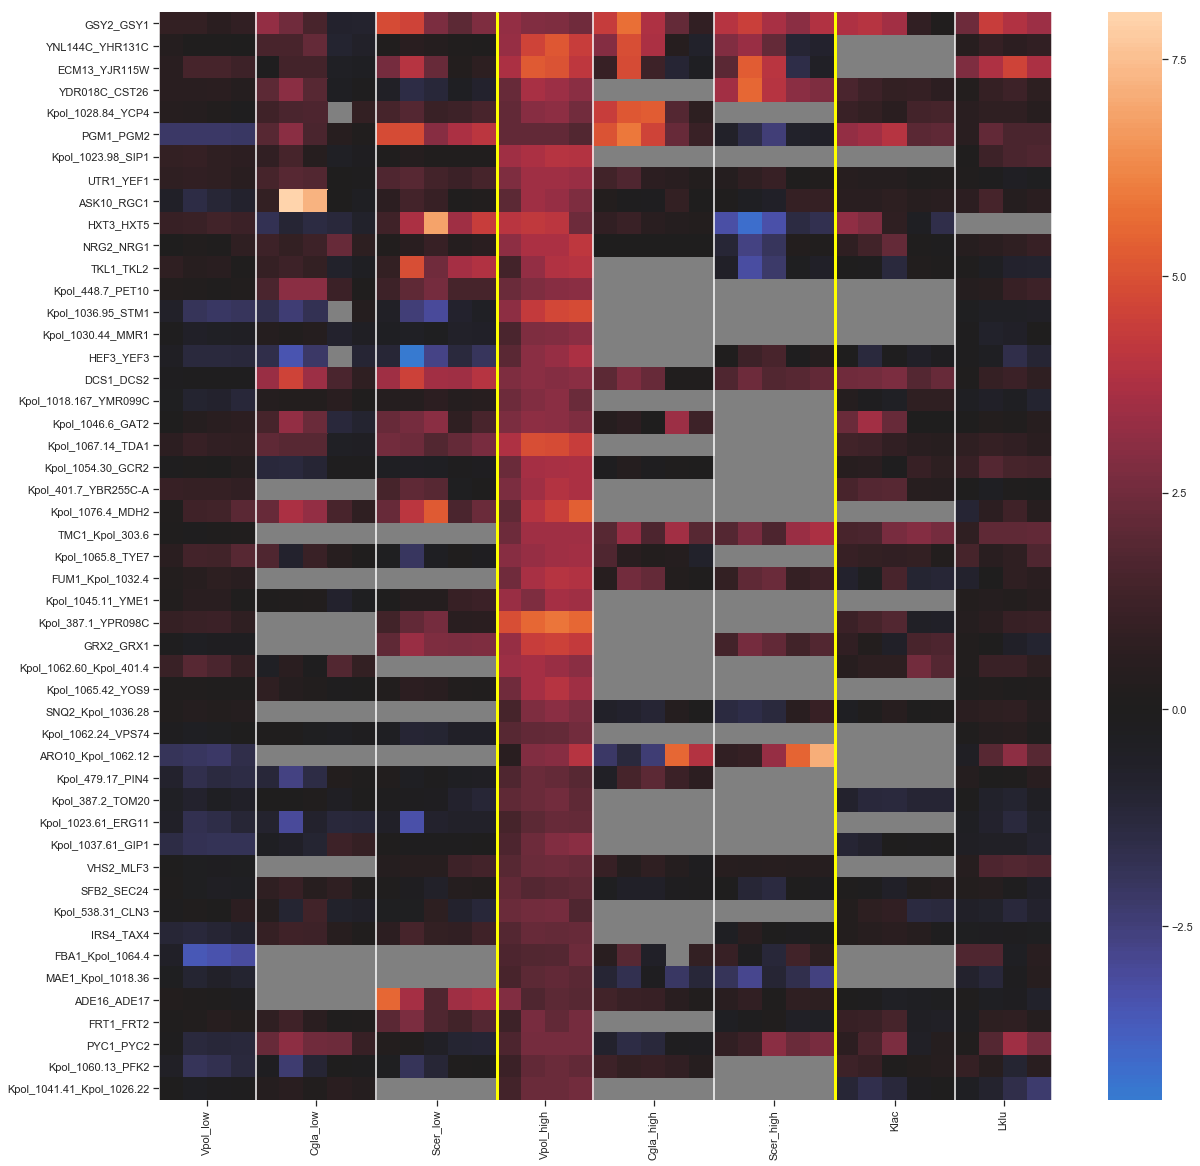

In [98]:
#heatmap after filtering and sorting

fig_hmap_exp, ax_hmap_exp = plt.subplots(figsize=(20,20))

#Make subset that only has columns with appropriate conditions:
conds_pka_corr = ['DS/LOG', 'PS/LOG', 'PLAT/LOG',
                    'heat shock_030', 'heat shock_045']

new_columns = []
for column in expression_data_df_sorted.columns: 
    pass_test = False
    for cond in conds_pka_corr:
        if cond in column: 
            pass_test=True

    if pass_test:
        new_columns.append(column)
        
expression_data_df_pka_corr = expression_data_df_sorted.loc[:,new_columns]    
   

#Make labels for each species, and separate out pre/post WGH and post WGH high/low with yellow lines
N_spec_level = {}

label_order = []
for level in ['low','high']:
    for spec in spec_sets['Post WGH ' + level]:
        label = spec + '_' + level
        N_spec_level[label] = 0
        label_order.append(label)
for spec in spec_sets['Pre WGH']: 
    label = spec
    N_spec_level[label] = 0 
    label_order.append(label)


for column in expression_data_df_pka_corr.columns: 
    spec = column.split('_')[0]
    if spec in set(spec_sets['Post WGH low']):
        level_sep = '_'
        level = column.split('_')[-1]
    else: 
        level_sep = ''
        level = ''
    label = spec + level_sep + level
    N_spec_level[label] = N_spec_level[label] + 1
    
new_ticks = []
sep_lines = [0]
new_tick_labels = []
big_lines = []
tick_tracker = 0
for label in label_order:
    N_tick_dist = N_spec_level[label]
    new_ticks.append(tick_tracker + N_tick_dist/2)
    new_tick_labels.append(label)
    sep_lines.append(tick_tracker + N_tick_dist)
    #new_tick_labels.append('')
    tick_tracker = tick_tracker + N_tick_dist
    if label in {'Scer_low', 'Scer_high'}:
        big_lines.append(tick_tracker)



sns.heatmap(expression_data_df_pka_corr, center = 0.0, xticklabels=False, ax = ax_hmap_exp)
ax_hmap_exp.set_facecolor('grey')
ax_hmap_exp.set_xticks(new_ticks)
ax_hmap_exp.set_xticklabels(new_tick_labels, rotation = 90)  #rotation=45, ha='right')
ax_hmap_exp.vlines(sep_lines, ymin = 0, ymax = len(expression_data_df_pka_corr), colors = 'white')
ax_hmap_exp.vlines(big_lines, ymin = 0, ymax = len(expression_data_df_pka_corr), colors = 'yellow',linewidth=3)
ax_hmap_exp.set_rasterized(True)    #Had to do this because .svg took ages on inkscape to work with
fig_hmap_exp.savefig(os.path.normpath('C:/Users/BMH_work/Google Drive/UCSF/ElSamad_Lab/PKA/Manuscript/exp_goi_regev_VP_PKA_est_corr.svg'))